In [1]:
# models/models_ran.ipynb

# 📌 שלב 1: ייבוא ספריות
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

# 📌 שלב 2: הגדרות בסיס
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid', palette='pastel')
plt.rcParams['figure.figsize'] = (12, 6)

# 📌 שלב 3: קריאת הקובץ המעודכן ביותר
notebook_path = os.getcwd() 
excel_path = os.path.join(notebook_path,"..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)

# בדיקה מה יש בגליונות
xls = pd.ExcelFile(excel_path)
print("Available sheets:", xls.sheet_names)

# 📌 שלב 4: טען את הגיליון שתרצה (לדוגמה - גיליון ראשון)
df = pd.read_excel(xls, sheet_name=0)  # אפשר גם sheet_name="שם_גיליון"

# תצוגה ראשונית של הנתונים
print("Shape:", df.shape)
df.head()


Available sheets: ['Sheet1']
Shape: (7737, 42)


,מספר מטופל רנדומלי,מספר מקרה אשפוז רנדומלי,נקבה,גיל אשפוז,מצב משפחתי_גרוש/ה,מצב משפחתי_נשוי/א,מצב משפחתי_רווק/ה,קטגוריית גורם מפנה_בית חולים,קטגוריית גורם מפנה_גורמי משפט וביטחון,קטגוריית גורם מפנה_מוסד רפואי אחר,קטגוריית גורם מפנה_פניה עצמית,קטגוריית גורם מפנה_פסיכיאטר מחוזי,קטגוריית הופנה ל_טיפול מרפאתי,קטגוריית הופנה ל_מוסדות,קטגוריית הופנה ל_מרפאה פסיכיאטרית,קטגוריית הופנה ל_רופא מטפל,קטגוריית הופנה ל_ריק,קטגוריית סטטוס חוקי_אשפוז בהסכמה,קטגוריית סטטוס חוקי_אשפוז כפוי,קטגוריית סטטוס חוקי_אשפוז כפוי דחוף,קטגוריית סטטוס חוקי_גורמים משפטיים,אזור מוצא_אתיופיה,אזור מוצא_ברית המועצות,אזור מוצא_ישראל,גיל עליה,חזר לאשפוז תוך חודש,חזר לאשפוז תוך 3 חודשים,Month_January,Month_February,Month_March,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December,Year_2021,Year_2022,Year_2023,Year_2024
0,4,47098,0,0.263158,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0.21519,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,24,77161,0,0.473684,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,1,0,0,0,1,NaN,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,24,81610,0,0.486842,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,NaN,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,24,15554,0,0.486842,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,24,24408,0,0.500000,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [2]:
# 📌 שלב 5.2: יצירת שני קבצים – עם ובלי דאמיז שנה – שמירה באותה תיקייה

import os
import pandas as pd

# קריאת קובץ המקור (עדכון 46)
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..",
    "Excel_Updates", "Update 46 - Remove Dominant Binary Columns",
    "removed_dominant_binary_columns.xlsx"
)
df_original = pd.read_excel(excel_path)

# מפת חודש -> שם באנגלית
month_map = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}

# סדר חודשים כרונולוגי
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# יצירת תיקייה משותפת לשני הקבצים
save_folder = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison")
if not os.path.exists(save_folder):
    os.makedirs(save_folder)
    print("📂 נוצרה תיקייה:", save_folder)

# ========================
# קובץ 1: month_only.xlsx
# ========================
df_month_only = df_original.copy()

# הסרת עמודת השנה
if "שנת כניסה" in df_month_only.columns:
    df_month_only.drop(columns=["שנת כניסה"], inplace=True)

# המרת חודש לשם באנגלית
df_month_only['חודש כניסה'] = df_month_only['חודש כניסה'].astype(int).map(month_map)

# One-Hot רק לחודשים
df_month_only = pd.get_dummies(df_month_only, columns=['חודש כניסה'], prefix='Month', drop_first=True)

# סידור העמודות
month_cols = [f"Month_{m}" for m in month_order if f"Month_{m}" in df_month_only.columns]
other_cols = [col for col in df_month_only.columns if not col.startswith("Month_")]
df_month_only = df_month_only[other_cols + month_cols]

# שמירה
path1 = os.path.join(save_folder, "month_only.xlsx")
df_month_only.to_excel(path1, index=False)
print("✅ נשמר: רק חודש, ללא שנה →", path1)

# ==========================
# קובץ 2: month_year.xlsx
# ==========================
df_month_year = df_original.copy()

# המרת חודש ושנה
df_month_year['חודש כניסה'] = df_month_year['חודש כניסה'].astype(int).map(month_map)
df_month_year['שנת כניסה'] = df_month_year['שנת כניסה'].astype(int)

# One-Hot לחודש + שנה
df_month_year = pd.get_dummies(df_month_year, columns=['חודש כניסה', 'שנת כניסה'],
                                prefix=['Month', 'Year'], drop_first=True)

# סידור העמודות
month_cols = [f"Month_{m}" for m in month_order if f"Month_{m}" in df_month_year.columns]
year_order = sorted([int(c.split('_')[1]) for c in df_month_year.columns if c.startswith('Year_')])
year_cols = [f"Year_{y}" for y in year_order]
other_cols = [col for col in df_month_year.columns if not col.startswith("Month_") and not col.startswith("Year_")]
df_month_year = df_month_year[other_cols + month_cols + year_cols]

# שמירה
path2 = os.path.join(save_folder, "month_year.xlsx")
df_month_year.to_excel(path2, index=False)
print("✅ נשמר: חודש + שנה →", path2)


✅ נשמר: רק חודש, ללא שנה → ..\Excel_Updates\Update 48 - Month Dummy Comparison\month_only.xlsx
✅ נשמר: חודש + שנה → ..\Excel_Updates\Update 48 - Month Dummy Comparison\month_year.xlsx



✅ בדיקת פיצ'רים חשובים עבור הקובץ: month_only
                                  Feature  Coefficient
7       קטגוריית גורם מפנה_מוסד רפואי אחר     0.600280
15       קטגוריית סטטוס חוקי_אשפוז בהסכמה     0.526863
19                      אזור מוצא_אתיופיה     0.390551
21                        אזור מוצא_ישראל     0.363464
31                          Month_October     0.342905
1                               גיל אשפוז     0.311142
5            קטגוריית גורם מפנה_בית חולים     0.297796
10          קטגוריית הופנה ל_טיפול מרפאתי     0.296586
28                             Month_July     0.260388
32                         Month_November     0.242505
13             קטגוריית הופנה ל_רופא מטפל     0.239311
24                         Month_February     0.218072
30                        Month_September     0.217716
12      קטגוריית הופנה ל_מרפאה פסיכיאטרית     0.177341
6   קטגוריית גורם מפנה_גורמי משפט וביטחון     0.158679
📁 הקובץ נשמר בהצלחה ב־: ../Excel_Updates/Update 49 - Selected Top 15 Feat

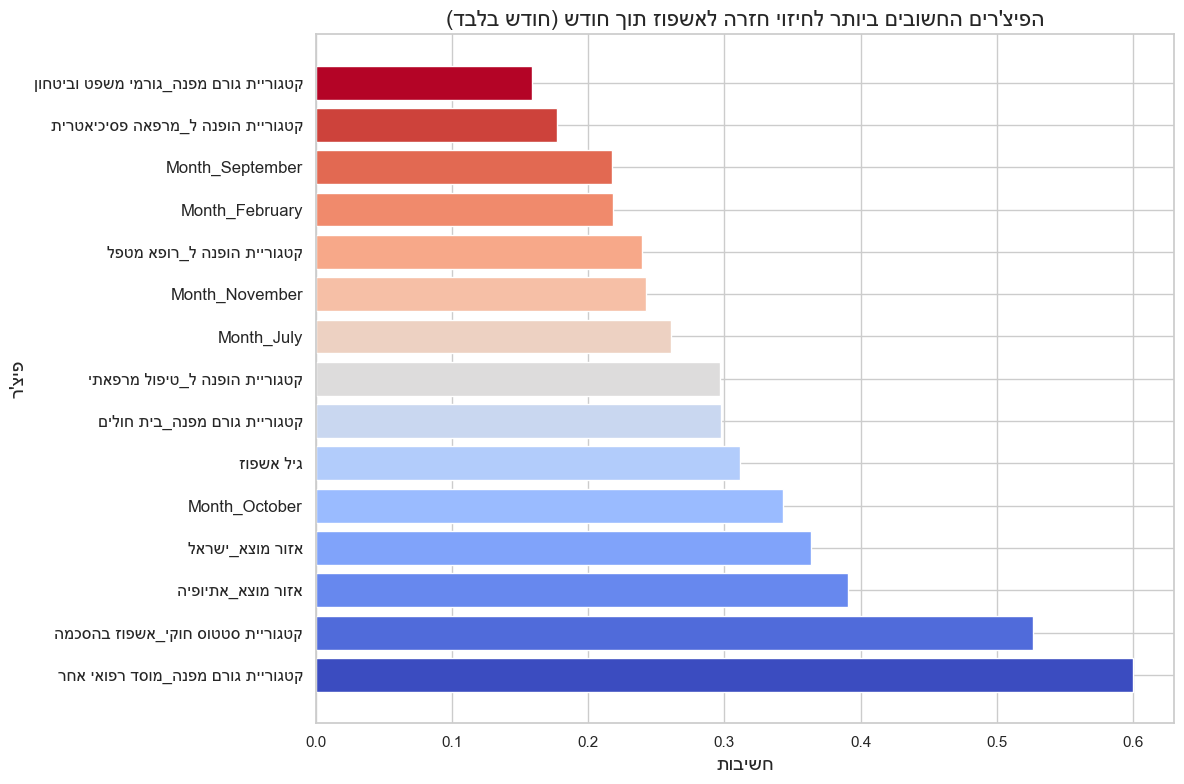


✅ בדיקת פיצ'רים חשובים עבור הקובץ: month_year
                              Feature  Coefficient
7   קטגוריית גורם מפנה_מוסד רפואי אחר     0.619664
15   קטגוריית סטטוס חוקי_אשפוז בהסכמה     0.546575
19                  אזור מוצא_אתיופיה     0.394682
21                    אזור מוצא_ישראל     0.367929
31                      Month_October     0.346020
1                           גיל אשפוז     0.334116
5        קטגוריית גורם מפנה_בית חולים     0.305384
10      קטגוריית הופנה ל_טיפול מרפאתי     0.280698
28                         Month_July     0.263250
13         קטגוריית הופנה ל_רופא מטפל     0.251638
32                     Month_November     0.234391
30                    Month_September     0.220639
24                     Month_February     0.217816
12  קטגוריית הופנה ל_מרפאה פסיכיאטרית     0.180651
8       קטגוריית גורם מפנה_פניה עצמית     0.160005
📁 הקובץ נשמר בהצלחה ב־: ../Excel_Updates/Update 49 - Selected Top 15 Features\top15_month_year.xlsx


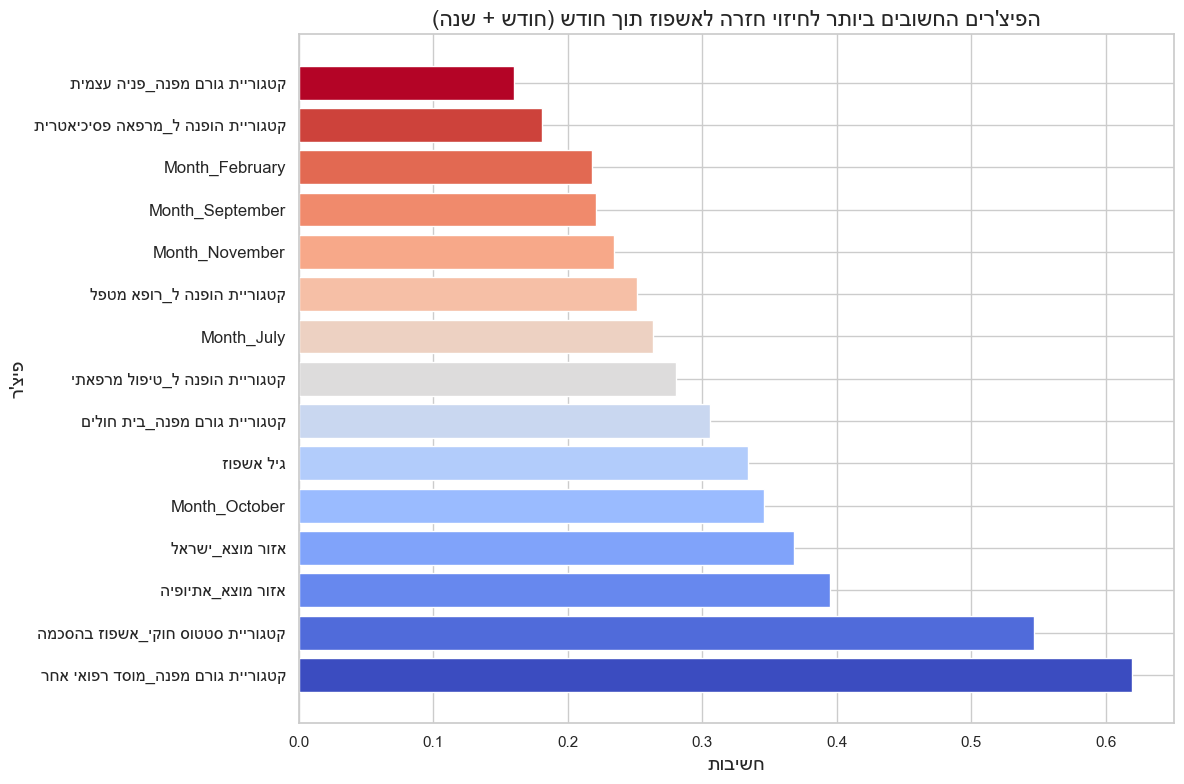

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import seaborn as sns
import arabic_reshaper
from bidi.algorithm import get_display
import numpy as np
import os

# 📌 פונקציה לתמיכה בשפות RTL (עברית/ערבית)
def fix_rtl(texts):
    return [get_display(arabic_reshaper.reshape(t)) for t in texts]

# 📌 שלב 1: קריאת הקובץ והחזרת 15 הפיצ'רים החשובים ביותר
def get_important_features_logreg(file_path):
    df = pd.read_excel(file_path)  # טוענים את הדאטה מקובץ Excel

    # 📌 הסרת מזהים (למנוע כפילויות ונתונים רגישים)
    df = df.drop(columns=["מספר מקרה אשפוז רנדומלי", "מספר מטופל רנדומלי"], errors="ignore")

    # 📌 הגדרת עמודת המטרה
    target_col = "חזר לאשפוז תוך חודש"
    X = df.drop(columns=[target_col, "חזר לאשפוז תוך 3 חודשים"], errors="ignore")
    y = df[target_col]

    # 📌 שלב 2: מילוי ערכים חסרים (NaN)
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

    # 📌 שלב 3: חלוקה לסט אימון וסט בדיקה
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 📌 שלב 4: אימון מודל רגרסיה לוגיסטית
    logreg = LogisticRegression(max_iter=1000)
    logreg.fit(X_train, y_train)

    # 📌 שלב 5: שליפת coefficients של הפיצ'רים
    coefficients = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': logreg.coef_[0]
    }).sort_values(by='Coefficient', ascending=False)

    # 📌 שלב 6: החזרת 15 הפיצ'רים החשובים ביותר
    return coefficients.head(15)

# 📁 קבצים לבדוק
file_paths = {
    "month_only": "../Excel_Updates/Update 48 - Month Dummy Comparison/month_only.xlsx",
    "month_year": "../Excel_Updates/Update 48 - Month Dummy Comparison/month_year.xlsx"
}

# 📁 תיקיית שמירה
output_folder = "../Excel_Updates/Update 49 - Selected Top 15 Features"
os.makedirs(output_folder, exist_ok=True)

# 📌 שלב 7: ריצה על כל קובץ
for key, path in file_paths.items():
    print(f"\n✅ בדיקת פיצ'רים חשובים עבור הקובץ: {key}")

    # 📌 שליפת 15 פיצ'רים
    top_features = get_important_features_logreg(path)
    print(top_features)

    # 📁 שמירה לקובץ Excel
    save_path = os.path.join(output_folder, f"top15_{key}.xlsx")
    top_features.to_excel(save_path, index=False)
    print(f"📁 הקובץ נשמר בהצלחה ב־: {save_path}")

    # 📊 שלב 8: גרף עמודות מקצועי
    plt.figure(figsize=(12, 8))
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(np.linspace(0, 1, len(top_features)))

    bars = plt.barh(fix_rtl(top_features['Feature']), top_features['Coefficient'], color=colors)
    plt.yticks(rotation=0, ha='right', fontsize=12)

    # כותרת ברורה לכל קובץ
    title = "הפיצ'רים החשובים ביותר לחיזוי חזרה לאשפוז תוך חודש (חודש בלבד)" \
        if key == "month_only" else \
        "הפיצ'רים החשובים ביותר לחיזוי חזרה לאשפוז תוך חודש (חודש + שנה)"
    plt.title(get_display(arabic_reshaper.reshape(title)), fontsize=16)
    plt.xlabel(get_display(arabic_reshaper.reshape("חשיבות")), fontsize=14)
    plt.ylabel(get_display(arabic_reshaper.reshape("פיצ'ר")), fontsize=14)
    plt.tight_layout()
    plt.show()


In [56]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler  # ✅ הוספנו את RandomOverSampler

# 📌 שלב 1: טען את הקובץ לבדיקה מהירה
df = pd.read_excel("../Excel_Updates/Update 48 - Month Dummy Comparison/month_only.xlsx")
value_counts = df["חזר לאשפוז תוך חודש"].value_counts()
percentages = df["חזר לאשפוז תוך חודש"].value_counts(normalize=True) * 100

print("🔢 התפלגות ערכים:")
print(value_counts)
print("\n📊 אחוזים:")
print(percentages.round(2))
print(f"\n📈 יחס בין 1 ל-0: {value_counts[1] / value_counts[0]:.3f}")



🔢 התפלגות ערכים:
0    6436
1    1301
Name: חזר לאשפוז תוך חודש, dtype: int64

📊 אחוזים:
0    83.18
1    16.82
Name: חזר לאשפוז תוך חודש, dtype: float64

📈 יחס בין 1 ל-0: 0.202


In [74]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from tabulate import tabulate

# 📁 נתיבים לקבצים
base_dir = "../Excel_Updates"
data_files = {
    "month_only": os.path.join(base_dir, "Update 48 - Month Dummy Comparison", "month_only.xlsx"),
    "month_year": os.path.join(base_dir, "Update 48 - Month Dummy Comparison", "month_year.xlsx"),
}
features_files = {
    "month_only": os.path.join(base_dir, "Update 49 - Selected Top 15 Features", "top15_month_only.xlsx"),
    "month_year": os.path.join(base_dir, "Update 49 - Selected Top 15 Features", "top15_month_year.xlsx"),
}

target = "חזר לאשפוז תוך חודש"
id_column = "מספר מטופל רנדומלי"

# 📌 פונקציה להרצת המודל
def evaluate_model(X, y, sampler=None, model_type="logistic", class_weight=None, scale_pos_weight=None):
    if sampler:
        X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y)

    if model_type == "logistic":
        model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    elif model_type == "xgboost":
        model = XGBClassifier(eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=42)
    else:
        return None

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)

    return {
        "Precision": round(report["1"]["precision"], 3),
        "Recall": round(report["1"]["recall"], 3),
        "F1-Score": round(report["1"]["f1-score"], 3),
        "AUC": round(auc, 3)
    }

# 📌 הרצת כל שיטות האיזון על כל אחד מהקבצים
for name in data_files:
    print(f"\n====== קובץ: {name} ======")

    df = pd.read_excel(data_files[name])
    top_features = pd.read_excel(features_files[name])["Feature"].tolist()

    # 💾 שמירת מזהה המטופל (לא חובה אם לא משתמשים בו כאן)
    ids = df[id_column]

    # ✅ בחירת פיצ'רים
    X = df[top_features].copy()
    y = df[target]

    # ✅ ניקוי NaN
    X = X.fillna(X.mean(numeric_only=True))
    mask = y.notna()
    X = X[mask]
    y = y[mask]

    # ✅ יחס בין מחלקות
    ratio = y.value_counts()[0] / y.value_counts()[1]

    # 🧪 שיטות האיזון השונות
    methods = [
        ("Random UnderSampling", RandomUnderSampler(random_state=42), "logistic", None, None),
        ("Random OverSampling", RandomOverSampler(random_state=42), "logistic", None, None),
        ("SMOTE", SMOTE(random_state=42), "logistic", None, None),
        ("ADASYN", ADASYN(random_state=42), "logistic", None, None),
        ("SMOTEENN", SMOTEENN(random_state=42), "logistic", None, None),
        ("SMOTETomek", SMOTETomek(random_state=42), "logistic", None, None),
        ("Class Weight Balanced", None, "logistic", "balanced", None),
        ("XGBoost + scale_pos_weight", None, "xgboost", None, ratio),
        ("Manual Under+Over", Pipeline([
            ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
            ('over', RandomOverSampler(sampling_strategy=1.0, random_state=42))
        ]), "logistic", None, None),
    ]

    # 🧾 שמירת התוצאות
    local_results = []

    for method_name, sampler, model_type, class_weight, spw in methods:
        scores = evaluate_model(X, y, sampler=sampler, model_type=model_type,
                                class_weight=class_weight, scale_pos_weight=spw)
        local_results.append({
            "שיטה": method_name,
            "Precision": scores["Precision"],
            "Recall": scores["Recall"],
            "F1-Score": scores["F1-Score"],
            "AUC": scores["AUC"]
        })

    # 🖨️ הדפסת טבלת התוצאות
    print(f"\n📊 השוואת שיטות איזון לקובץ: {name} (ממויינת לפי F1-Score):\n")
    sorted_table = sorted(local_results, key=lambda x: x["F1-Score"], reverse=True)
    print(tabulate(sorted_table, headers="keys", tablefmt="fancy_grid", showindex=False))



====== קובץ: month_only ======

📊 השוואת שיטות איזון לקובץ: month_only (ממויינת לפי F1-Score):

╒════════════════════════════╤═════════════╤══════════╤════════════╤═══════╕
│ שיטה                       │   Precision │   Recall │   F1-Score │   AUC │
╞════════════════════════════╪═════════════╪══════════╪════════════╪═══════╡
│ Random UnderSampling       │       0.571 │    0.727 │      0.64  │ 0.629 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ SMOTE                      │       0.56  │    0.741 │      0.638 │ 0.588 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ SMOTETomek                 │       0.559 │    0.713 │      0.627 │ 0.598 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ Manual Under+Over          │       0.579 │    0.673 │      0.622 │ 0.626 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ Random OverSampling        │       0.551 │    0.674 │ 

KeyError: '1'

In [64]:
import pandas as pd
import os
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

# 📁 נתיבים לקבצים המקוריים
base_dir = "../Excel_Updates"
update_48_dir = os.path.join(base_dir, "Update 48 - Month Dummy Comparison")
update_49_dir = os.path.join(base_dir, "Update 49 - Selected Top 15 Features")
update_50_dir = os.path.join(base_dir, "Update 50 - Balanced All vs Top15")
os.makedirs(update_50_dir, exist_ok=True)

# 📌 עמודת המטרה
target = "חזר לאשפוז תוך חודש"

# 📁 קבצים
files = {
    "month_only": {
        "data": os.path.join(update_48_dir, "month_only.xlsx"),
        "top15": os.path.join(update_49_dir, "top15_month_only.xlsx"),
        "balancer": RandomUnderSampler(random_state=42),
    },
    "month_year": {
        "data": os.path.join(update_48_dir, "month_year.xlsx"),
        "top15": os.path.join(update_49_dir, "top15_month_year.xlsx"),
        "balancer": SMOTETomek(random_state=42),
    }
}

# 📌 עיבוד כל קובץ
for name, paths in files.items():
    # קריאת קובץ
    df = pd.read_excel(paths["data"])

    # הסרת מזהים
    df = df.drop(columns=["מספר מקרה אשפוז רנדומלי", "מספר מטופל רנדומלי"], errors="ignore")

    # שמירה של כל הפיצ'רים
    df_all = df.copy()
    df_all.fillna(df_all.median(numeric_only=True), inplace=True)
    X_all = df_all.drop(columns=[target, "חזר לאשפוז תוך 3 חודשים"], errors="ignore")
    y_all = df_all[target]
    X_all_bal, y_all_bal = paths["balancer"].fit_resample(X_all, y_all)
    df_all_bal = pd.concat([X_all_bal, y_all_bal], axis=1)
    df_all_bal.to_excel(os.path.join(update_50_dir, f"{name}_all_features_balanced.xlsx"), index=False)

    # שמירה רק של 15 הפיצ'רים החשובים
    top_features = pd.read_excel(paths["top15"])["Feature"].tolist()
    df_top = df.copy()
    df_top.fillna(df_top.median(numeric_only=True), inplace=True)
    X_top = df_top[top_features]
    y_top = df_top[target]
    X_top_bal, y_top_bal = paths["balancer"].fit_resample(X_top, y_top)
    df_top_bal = pd.concat([X_top_bal, y_top_bal], axis=1)
    df_top_bal.to_excel(os.path.join(update_50_dir, f"{name}_top15_features_balanced.xlsx"), index=False)

print("✅ כל הקבצים נוצרו והוזנו בהצלחה בתיקייה Update 50 - Balanced All vs Top15")


✅ כל הקבצים נוצרו והוזנו בהצלחה בתיקייה Update 50 - Balanced All vs Top15


In [45]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from tabulate import tabulate

# 📁 נתיבים לקבצים
base_dir = "../Excel_Updates"
data_files = {
    "month_only": os.path.join(base_dir, "Update 48 - Month Dummy Comparison", "month_only.xlsx"),
    "month_year": os.path.join(base_dir, "Update 48 - Month Dummy Comparison", "month_year.xlsx"),
}
features_files = {
    "month_only": os.path.join(base_dir, "Update 49 - Selected Top 15 Features", "top15_month_only.xlsx"),
    "month_year": os.path.join(base_dir, "Update 49 - Selected Top 15 Features", "top15_month_year.xlsx"),
}

target = "חזר לאשפוז תוך חודש"
id_column = "מספר מטופל רנדומלי"

# 📌 פונקציה להרצת המודל
def evaluate_model(X, y, sampler=None, model_type="logistic", class_weight=None, scale_pos_weight=None):
    if sampler:
        X, y = sampler.fit_resample(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    if model_type == "logistic":
        model = LogisticRegression(max_iter=1000, class_weight=class_weight)
    elif model_type == "xgboost":
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                              scale_pos_weight=scale_pos_weight, random_state=42)
    else:
        return None

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    auc = roc_auc_score(y_test, y_prob)

    return {
        "Precision": round(report["1"]["precision"], 3),
        "Recall": round(report["1"]["recall"], 3),
        "F1-Score": round(report["1"]["f1-score"], 3),
        "AUC": round(auc, 3)
    }

# 📌 הרצת כל שיטות האיזון על כל אחד מהקבצים
for name in data_files:
    df = pd.read_excel(data_files[name])
    top_features = pd.read_excel(features_files[name])["Feature"].tolist()

    # 💾 שמירת מזהה המטופל
    ids = df[id_column]

    # ✅ כולל רק את הפיצ'רים הנבחרים ולא שוכחים לשמור את מזהה המטופל בצד אם צריך אותו
    X = df[top_features].copy()
    y = df[target]
    X = X.fillna(X.mean(numeric_only=True))

    ratio = y.value_counts()[0] / y.value_counts()[1]

    methods = [
        ("Random UnderSampling", RandomUnderSampler(random_state=42), "logistic", None, None),
        ("Random OverSampling", RandomOverSampler(random_state=42), "logistic", None, None),
        ("SMOTE", SMOTE(random_state=42), "logistic", None, None),
        ("ADASYN", ADASYN(random_state=42), "logistic", None, None),
        ("SMOTEENN", SMOTEENN(random_state=42), "logistic", None, None),
        ("SMOTETomek", SMOTETomek(random_state=42), "logistic", None, None),
        ("Class Weight Balanced", None, "logistic", "balanced", None),
        ("XGBoost + scale_pos_weight", None, "xgboost", None, ratio),
        ("Manual Under+Over", Pipeline([
            ('under', RandomUnderSampler(sampling_strategy=0.5, random_state=42)),
            ('over', RandomOverSampler(sampling_strategy=1.0, random_state=42))
        ]), "logistic", None, None),
    ]

    local_results = []

    for method_name, sampler, model_type, class_weight, spw in methods:
        scores = evaluate_model(X, y, sampler=sampler, model_type=model_type,
                                class_weight=class_weight, scale_pos_weight=spw)
        local_results.append({
            "שיטה": method_name,
            "Precision": scores["Precision"],
            "Recall": scores["Recall"],
            "F1-Score": scores["F1-Score"],
            "AUC": scores["AUC"]
        })

    # 🖨️ הדפסת הטבלה לקובץ הנוכחי
    print(f"\n📊 השוואת שיטות איזון לקובץ: {name} (ממויין לפי F1-Score):\n")
    sorted_table = sorted(local_results, key=lambda x: x["F1-Score"], reverse=True)
    print(tabulate(sorted_table, headers="keys", tablefmt="fancy_grid", showindex=False))



📊 השוואת שיטות איזון לקובץ: month_only (ממויין לפי F1-Score):

╒════════════════════════════╤═════════════╤══════════╤════════════╤═══════╕
│ שיטה                       │   Precision │   Recall │   F1-Score │   AUC │
╞════════════════════════════╪═════════════╪══════════╪════════════╪═══════╡
│ Random UnderSampling       │       0.571 │    0.727 │      0.64  │ 0.629 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ SMOTE                      │       0.56  │    0.741 │      0.638 │ 0.588 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ SMOTETomek                 │       0.559 │    0.713 │      0.627 │ 0.598 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ Manual Under+Over          │       0.579 │    0.673 │      0.622 │ 0.626 │
├────────────────────────────┼─────────────┼──────────┼────────────┼───────┤
│ Random OverSampling        │       0.551 │    0.674 │      0.607 │ 0.592 │
├───────────

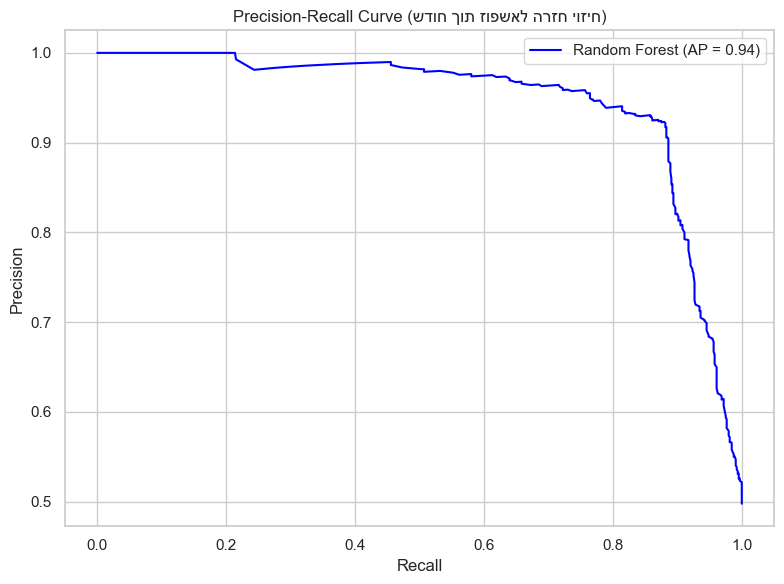

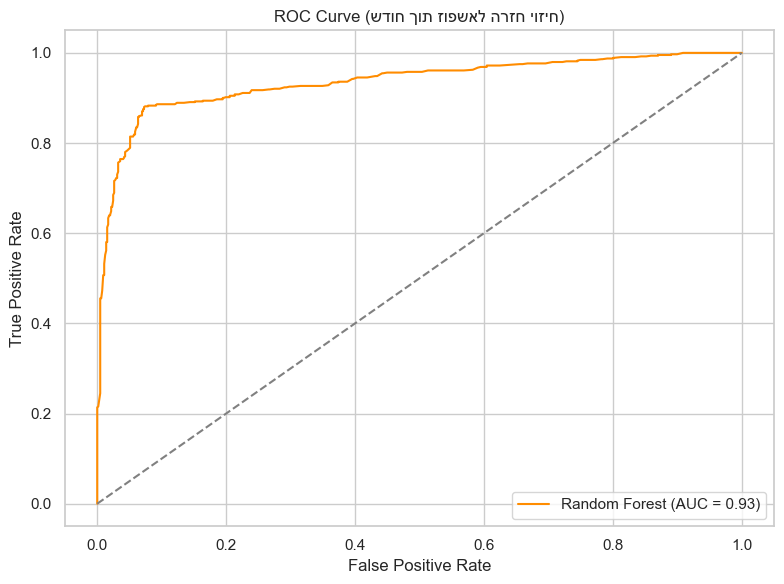


📊 Random Forest Model Performance Report

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Did Not Readmit    │        0.89 │ 0.83     │ 0.86       │ 647.00    │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.84 │ 0.89     │ 0.87       │ 641.00    │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Macro Average      │        0.86 │ 0.86     │ 0.86       │ 1288.00   │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Weighted Average   │        0.86 │ 0.86     │ 0.86       │ 1288.00   │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.93 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Avg Pr

In [77]:
# 📌 שלב 1: ייבוא ספריות
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tabulate import tabulate
from colorama import Fore, Style, init
import pandas as pd
import os

import arabic_reshaper
from bidi.algorithm import get_display

init(autoreset=True)  # לצביעה אוטומטית של טקסטים

# 📌 שלב 2: פונקציה לתיקון כיוון הטקסט בעברית
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# 📌 שלב 3: קריאת הקובץ המעודכן ביותר
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..",
    "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# הסרת עמודות מזהים רנדומליים שלא דרושים למודל
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# 📌 שלב 4: הגדרת עמודת המטרה והפרדת פיצ'רים
target_col = "חזר לאשפוז תוך חודש"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]

# טיפול בערכים חסרים
X.fillna(X.mean(), inplace=True)

# 📌 שלב 5: איזון הנתונים (Oversampling + Undersampling)
df_balanced = X.copy()
df_balanced[target_col] = y
df_majority = df_balanced[df_balanced[target_col] == 0]
df_minority = df_balanced[df_balanced[target_col] == 1]

df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // 2, random_state=42)
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_majority) // 2, random_state=42)

df_final = pd.concat([df_minority_oversampled, df_majority_undersampled])

# הפרדה מחדש לפיצ'רים ולמטרה לאחר האיזון
X_balanced = df_final.drop(columns=[target_col])
y_balanced = df_final[target_col]

# 📌 שלב 6: פיצול ל־Train ו־Test
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 📌 שלב 7: אימון מודל Random Forest
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 📌 שלב 8: חיזוי הסתברויות לקבוצת המבחן
y_scores = model.predict_proba(X_test)[:, 1]

# 📌 שלב 9: גרף Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.2f})', color='blue')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(fix_rtl("Precision-Recall Curve (חיזוי חזרה לאשפוז תוך חודש)"))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 שלב 10: גרף ROC + חישוב AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # קו מקרי
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(fix_rtl("ROC Curve (חיזוי חזרה לאשפוז תוך חודש)"))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 שלב 11: טבלת ביצועים עם שמות מובנים + צבעים


# Predict classes
y_pred = model.predict(X_test)

# Generate classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Mapping for label names
label_mapping = {
    "0.0": "Did Not Readmit",
    "1.0": "Readmitted",
    "macro avg": "Macro Average",
    "weighted avg": "Weighted Average"
}

# Build the table
report_table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        display_label = label_mapping.get(str(label), label)
        row = [display_label] + [f"{metrics[col]:.2f}" for col in ["precision", "recall", "f1-score", "support"]]
        report_table.append(row)

# Add overall performance metrics
report_table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
report_table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

# Print the table
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print("\n📊 Random Forest Model Performance Report\n")
print(tabulate(report_table, headers=headers, tablefmt="fancy_grid"))




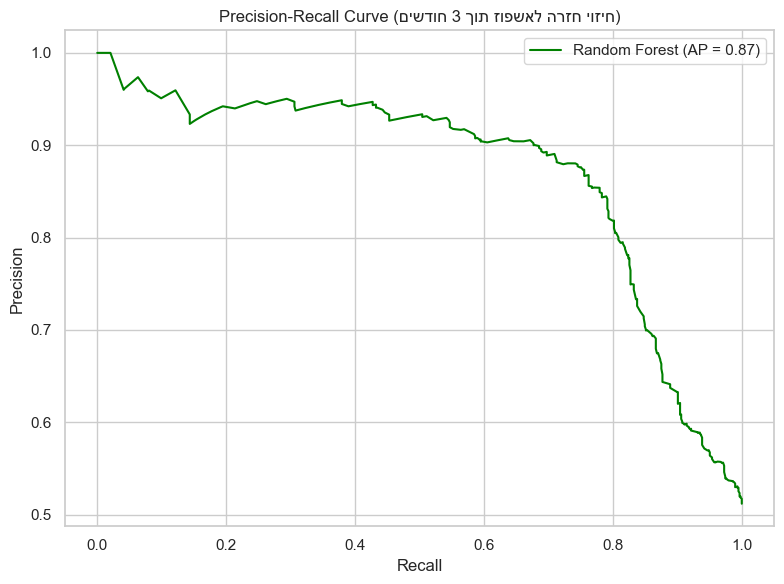

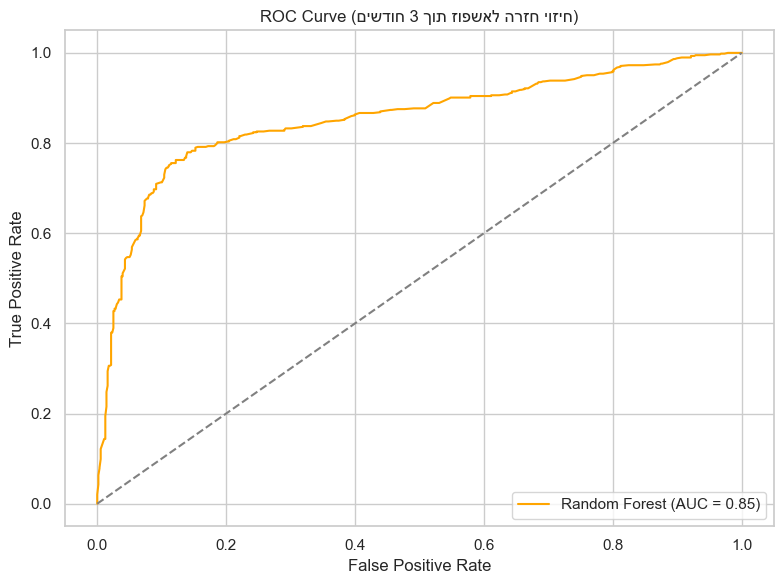


📊 Random Forest Model Performance Report (3-Month Readmission)

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Did Not Readmit    │        0.8  │ 0.75     │ 0.78       │ 558.00    │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.78 │ 0.83     │ 0.80       │ 585.00    │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Macro Average      │        0.79 │ 0.79     │ 0.79       │ 1143.00   │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Weighted Average   │        0.79 │ 0.79     │ 0.79       │ 1143.00   │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.85 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────

In [81]:
# 📌 שלב 1: ייבוא ספריות
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from tabulate import tabulate
import pandas as pd
import os

import arabic_reshaper
from bidi.algorithm import get_display

# 📌 שלב 2: פונקציה לתיקון כיוון טקסט בעברית
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# 📌 שלב 3: קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..",
    "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)
# הסרת מזהים שאינם נחוצים למודל
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# 📌 שלב 4: הגדרת משתנה מטרה (חזר תוך 3 חודשים) והפרדת פיצ'רים
target_col = "חזר לאשפוז תוך 3 חודשים"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)  # השלמת ערכים חסרים

# 📌 שלב 5: איזון נתונים – Oversampling ו־Undersampling
df_balanced = X.copy()
df_balanced[target_col] = y
df_majority = df_balanced[df_balanced[target_col] == 0]
df_minority = df_balanced[df_balanced[target_col] == 1]
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // 2, random_state=42)
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_majority) // 2, random_state=42)
df_final = pd.concat([df_minority_oversampled, df_majority_undersampled])

# 📌 שלב 6: פיצול ל־Train/Test
X_balanced = df_final.drop(columns=[target_col])
y_balanced = df_final[target_col]
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# 📌 שלב 7: אימון המודל
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 📌 שלב 8: חיזוי הסתברויות עבור קבוצת הבדיקה
y_scores = model.predict_proba(X_test)[:, 1]

# 📌 שלב 9: גרף Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Random Forest (AP = {avg_precision:.2f})', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(fix_rtl("Precision-Recall Curve (חיזוי חזרה לאשפוז תוך 3 חודשים)"))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 שלב 10: גרף ROC + AUC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc:.2f})', color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # קו מקרי
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(fix_rtl("ROC Curve (חיזוי חזרה לאשפוז תוך 3 חודשים)"))
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 שלב 11: טבלת ביצועים מסכמת באנגלית
y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)

# תרגום שמות לקטגוריות
label_mapping = {
    "0.0": "Did Not Readmit",
    "1.0": "Readmitted",
    "macro avg": "Macro Average",
    "weighted avg": "Weighted Average"
}

# בניית טבלה
report_table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        display_label = label_mapping.get(str(label), label)
        row = [display_label] + [f"{metrics[col]:.2f}" for col in ["precision", "recall", "f1-score", "support"]]
        report_table.append(row)

# הוספת ROC AUC ו־Average Precision
report_table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
report_table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

# הדפסת הטבלה
headers = ["Class", "Precision", "Recall", "F1-Score", "Support"]
print("\n📊 Random Forest Model Performance Report (3-Month Readmission)\n")
print(tabulate(report_table, headers=headers, tablefmt="fancy_grid"))


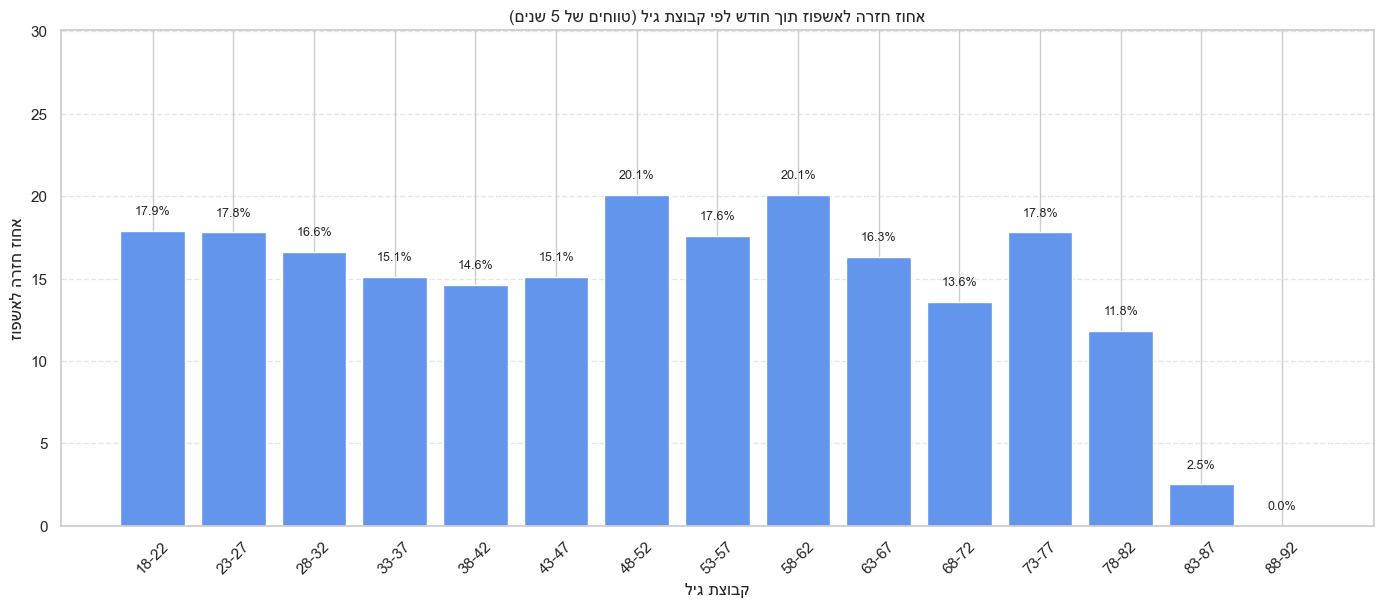


📊 Readmission Rate Within One Month by Age Group (Percentage & Count):

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│ Age Group   │   Readmission Rate (%) │   Count │   Returned Count │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-22       │                   17.9 │     848 │              152 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 23-27       │                   17.8 │    1283 │              229 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 28-32       │                   16.6 │     933 │              155 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 33-37       │                   15.1 │     936 │              141 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 38-42       │                   14.6 │     740 │              108 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 43-47       │  

In [83]:
# 📌 שלב 1: ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arabic_reshaper
from bidi.algorithm import get_display
from tabulate import tabulate

# 📌 שלב 2: פונקציה לתיקון כיוון עברית (לגרף בלבד)
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# 📌 שלב 3: קריאת קובץ הנתונים
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שלב 4: שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]  # סינון גילאים קטנים מ־18

# 📌 שלב 5: יצירת קבוצות גיל ידנית (טווחים של 5 שנים שמתחילים ב־18)
def age_group(age):
    if age >= 100:
        return "100+"
    base = 18
    width = 5
    lower = ((age - base) // width) * width + base
    upper = lower + width - 1
    return f"{lower}-{upper}"

df["Age Group"] = df["Recovered Age"].apply(age_group)

# 📌 שלב 6: חישוב אחוז חזרה תוך חודש לפי קבוצת גיל
grouped = df.groupby("Age Group")["חזר לאשפוז תוך חודש"].mean() * 100
grouped = grouped.round(1)

# 📌 שלב 6.1: חישוב כמות אנשים בכל קבוצת גיל
counts = df["Age Group"].value_counts().sort_index()

# 📌 שלב 6.2: חישוב כמות אנשים שחזרו לאשפוז (1 מתוך 0,1)
readmit_counts = df[df["חזר לאשפוז תוך חודש"] == 1]["Age Group"].value_counts().sort_index()

# 📌 שלב 6.3: איחוד כל הנתונים לטבלה אחת
final_table = pd.DataFrame({
    "Readmission Rate (%)": grouped,
    "Count": counts,
    "Returned Count": readmit_counts
}).reset_index(names="Age Group")

# 📌 שלב 7: מיון לפי התחלת הטווח (למשל: 18-22, 23-27...)
final_table["SortKey"] = final_table["Age Group"].apply(lambda val: int(val.split('-')[0]) if '-' in val else 100)
final_table = final_table.sort_values("SortKey").drop(columns="SortKey")

# 📌 שלב 8: גרף עם תוויות
plt.figure(figsize=(14, 6))
plt.bar(final_table["Age Group"], final_table["Readmission Rate (%)"], color="cornflowerblue")
plt.title(fix_rtl("אחוז חזרה לאשפוז תוך חודש לפי קבוצת גיל (טווחים של 5 שנים)"))
plt.ylabel(fix_rtl("אחוז חזרה לאשפוז"))
plt.xlabel(fix_rtl("קבוצת גיל"))
plt.ylim(0, final_table["Readmission Rate (%)"].max() + 10)

# תוויות אחוזים מעל כל עמודה
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 📌 שלב 9: טבלה באנגלית מתחת לגרף
print("\n📊 Readmission Rate Within One Month by Age Group (Percentage & Count):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


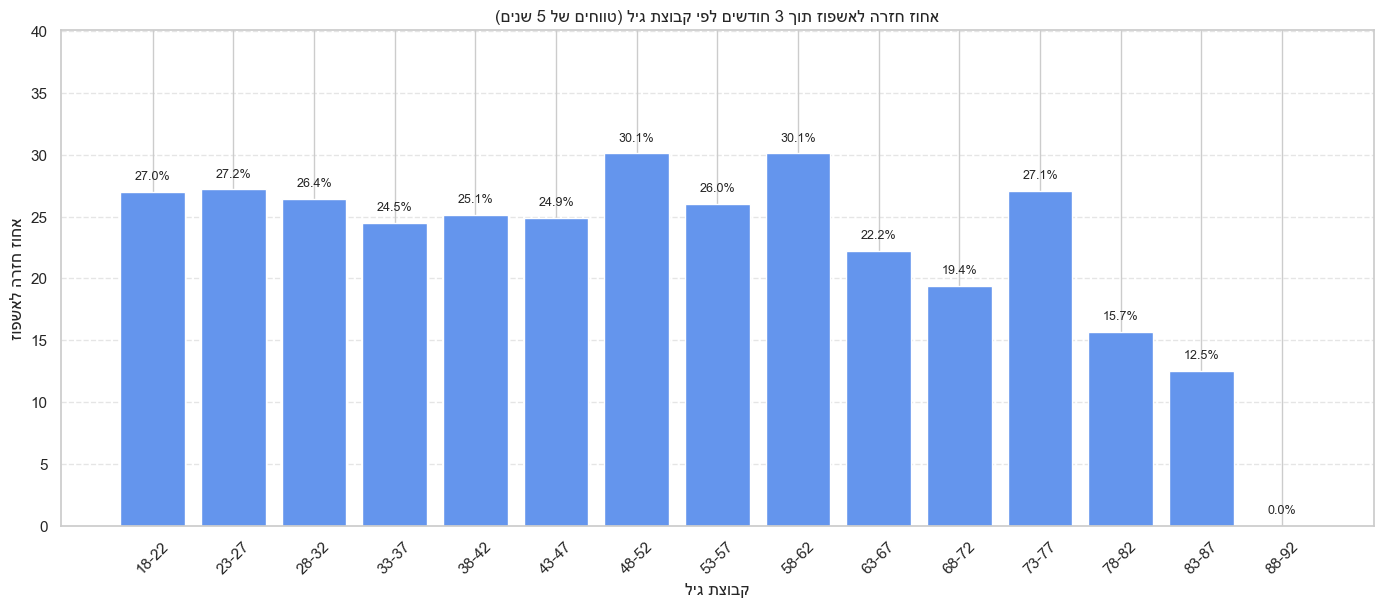


📊 Readmission Rate Within Three Months by Age Group:

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│ Age Group   │   Readmission Rate (%) │   Count │   Returned Count │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-22       │                   27   │     848 │              229 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 23-27       │                   27.2 │    1283 │              349 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 28-32       │                   26.4 │     933 │              246 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 33-37       │                   24.5 │     936 │              229 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 38-42       │                   25.1 │     740 │              186 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 43-47       │                   2

In [35]:
# 📌 שלב 1: ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import arabic_reshaper
from bidi.algorithm import get_display
from tabulate import tabulate

# 📌 שלב 2: פונקציה לתיקון כיוון עברית (לגרף בלבד)
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# 📌 שלב 3: קריאת קובץ הנתונים
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שלב 4: שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]  # סינון גילאים קטנים מ־18

# 📌 שלב 5: יצירת קבוצות גיל ידנית (טווחים של 5 שנים שמתחילים ב־18)
def age_group(age):
    if age >= 100:
        return "100+"
    base = 18
    width = 5
    lower = ((age - base) // width) * width + base
    upper = lower + width - 1
    return f"{lower}-{upper}"

df["Age Group"] = df["Recovered Age"].apply(age_group)

# 📌 שלב 6: חישוב אחוז חזרה לאשפוז תוך 3 חודשים לפי קבוצת גיל
grouped = df.groupby("Age Group")["חזר לאשפוז תוך 3 חודשים"].mean() * 100
grouped = grouped.round(1)

# 📌 שלב 6.1: חישוב כמות אנשים בכל קבוצת גיל
counts = df["Age Group"].value_counts().sort_index()

# 📌 שלב 6.2: חישוב כמות אנשים שחזרו לאשפוז (1 מתוך 0,1)
readmit_counts = df[df["חזר לאשפוז תוך 3 חודשים"] == 1]["Age Group"].value_counts().sort_index()

# 📌 שלב 6.3: איחוד כל הנתונים לטבלה אחת
final_table = pd.DataFrame({
    "Readmission Rate (%)": grouped,
    "Count": counts,
    "Returned Count": readmit_counts
}).reset_index(names="Age Group")

# 📌 שלב 6.4: מיון לפי התחלת הטווח (למשל: 18-22, 23-27...)
final_table["SortKey"] = final_table["Age Group"].apply(lambda val: int(val.split('-')[0]) if '-' in val else 100)
final_table = final_table.sort_values("SortKey").drop(columns="SortKey")

# 📌 שלב 7: גרף עם תוויות
plt.figure(figsize=(14, 6))
plt.bar(final_table["Age Group"], final_table["Readmission Rate (%)"], color="cornflowerblue")
plt.title(fix_rtl("אחוז חזרה לאשפוז תוך 3 חודשים לפי קבוצת גיל (טווחים של 5 שנים)"))
plt.ylabel(fix_rtl("אחוז חזרה לאשפוז"))
plt.xlabel(fix_rtl("קבוצת גיל"))
plt.ylim(0, final_table["Readmission Rate (%)"].max() + 10)

# תוויות אחוזים מעל כל עמודה
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 📌 שלב 8: טבלה באנגלית מתחת לגרף
print("\n📊 Readmission Rate Within Three Months by Age Group:\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


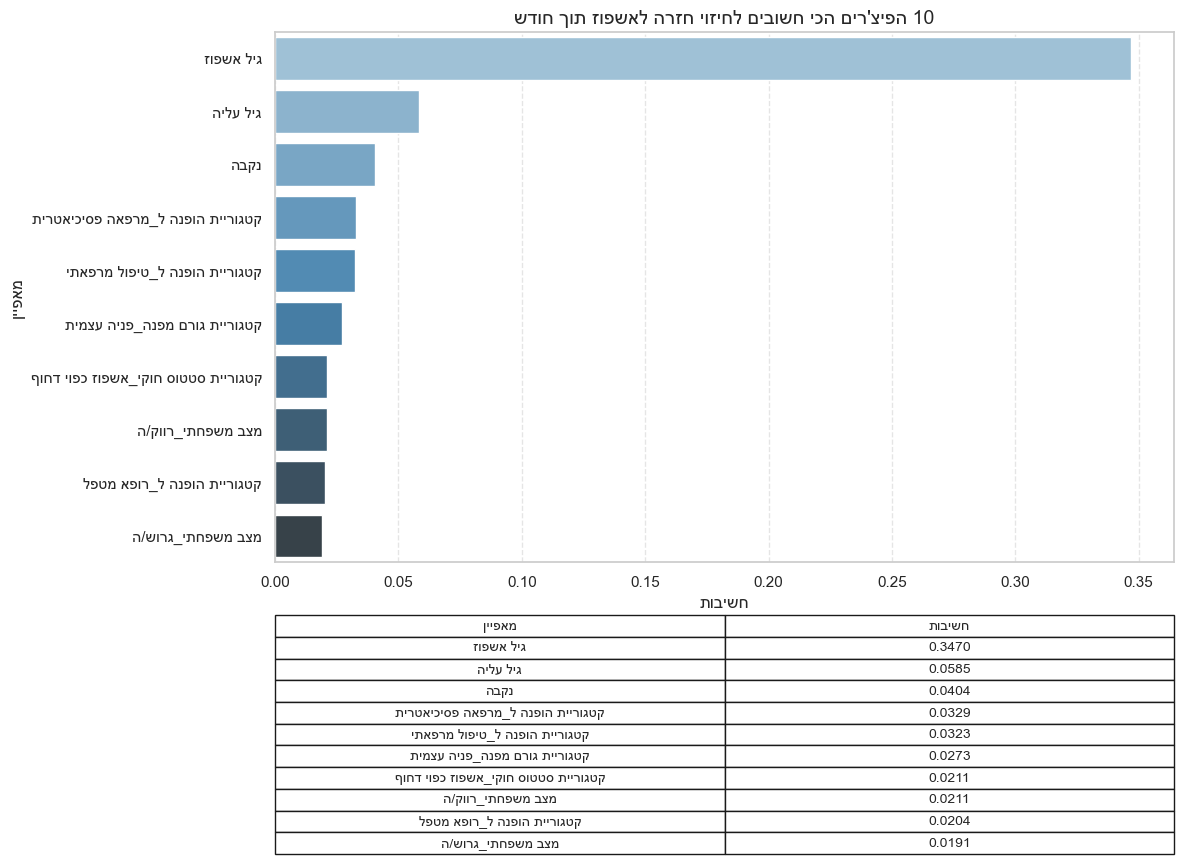

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.ticker as mticker
import matplotlib.table as tbl

# פונקציה לתיקון עברית
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# קריאת קובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_only.xlsx"
)
df = pd.read_excel(excel_path)

# הסרת מזהים רנדומליים
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# מטרה ופיצ'רים
target_col = "חזר לאשפוז תוך חודש"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# איזון נתונים
df_balanced = X.copy()
df_balanced[target_col] = y
df_majority = df_balanced[df_balanced[target_col] == 0]
df_minority = df_balanced[df_balanced[target_col] == 1]
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // 2, random_state=42)
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_majority) // 2, random_state=42)
df_final = pd.concat([df_minority_oversampled, df_majority_undersampled])

X_balanced = df_final.drop(columns=[target_col])
y_balanced = df_final[target_col]

# פיצול ואימון
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# חשיבות פיצ'רים
importances = model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({"Feature": features, "Importance": importances})
top_10 = feature_df.sort_values("Importance", ascending=False).head(10).reset_index(drop=True)
top_10["Feature"] = top_10["Feature"].apply(fix_rtl)

# גרף וטבלה מתחת
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_10, x="Importance", y="Feature", palette="Blues_d")
plt.title(fix_rtl("10 הפיצ'רים הכי חשובים לחיזוי חזרה לאשפוז תוך חודש"), fontsize=14)
plt.xlabel(fix_rtl("חשיבות"), fontsize=12)
plt.ylabel(fix_rtl("מאפיין"), fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# יצירת טבלה מתחת לגרף
table_data = [[row.Feature, f"{row.Importance:.4f}"] for row in top_10.itertuples()]
column_labels = [fix_rtl("מאפיין"), fix_rtl("חשיבות")]
the_table = plt.table(cellText=table_data, colLabels=column_labels, cellLoc='center',
                      loc='bottom', bbox=[0.0, -0.55, 1, 0.45])
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

plt.subplots_adjust(left=0.2, bottom=0.4)
plt.tight_layout()
plt.show()


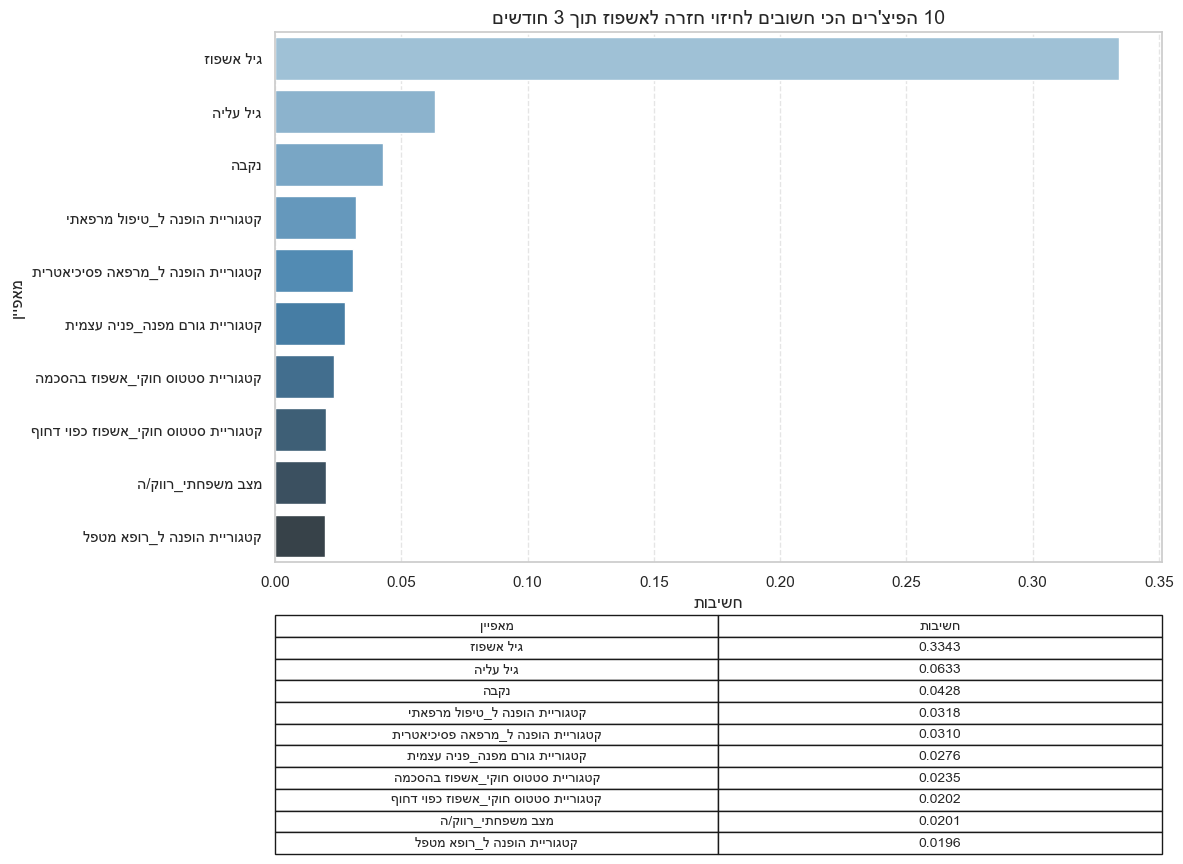

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.ticker as mticker

# 📌 שלב 1: פונקציה לתיקון עברית
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

# 📌 שלב 2: קריאת קובץ הנתונים
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_only.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שלב 3: הסרת מזהים רנדומליים אם קיימים
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# 📌 שלב 4: הגדרת מטרה ופיצ'רים
target_col = "חזר לאשפוז תוך 3 חודשים"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# 📌 שלב 5: איזון נתונים
df_balanced = X.copy()
df_balanced[target_col] = y
df_majority = df_balanced[df_balanced[target_col] == 0]
df_minority = df_balanced[df_balanced[target_col] == 1]
df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // 2, random_state=42)
df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_majority) // 2, random_state=42)
df_final = pd.concat([df_minority_oversampled, df_majority_undersampled])

X_balanced = df_final.drop(columns=[target_col])
y_balanced = df_final[target_col]

# 📌 שלב 6: פיצול ואימון
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)
model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# 📌 שלב 7: חשיבות פיצ'רים
importances = model.feature_importances_
features = X.columns
feature_df = pd.DataFrame({"Feature": features, "Importance": importances})
top_10 = feature_df.sort_values("Importance", ascending=False).head(10).reset_index(drop=True)
top_10["Feature"] = top_10["Feature"].apply(fix_rtl)

# 📌 שלב 8: גרף בר וטבלה
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_10, x="Importance", y="Feature", palette="Blues_d")
plt.title(fix_rtl("10 הפיצ'רים הכי חשובים לחיזוי חזרה לאשפוז תוך 3 חודשים"), fontsize=14)
plt.xlabel(fix_rtl("חשיבות"), fontsize=12)
plt.ylabel(fix_rtl("מאפיין"), fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# טבלה מתחת לגרף
table_data = [[row.Feature, f"{row.Importance:.4f}"] for row in top_10.itertuples()]
column_labels = [fix_rtl("מאפיין"), fix_rtl("חשיבות")]
the_table = plt.table(cellText=table_data, colLabels=column_labels, cellLoc='center',
                      loc='bottom', bbox=[0.0, -0.55, 1, 0.45])
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

plt.subplots_adjust(left=0.2, bottom=0.4)
plt.tight_layout()
plt.show()


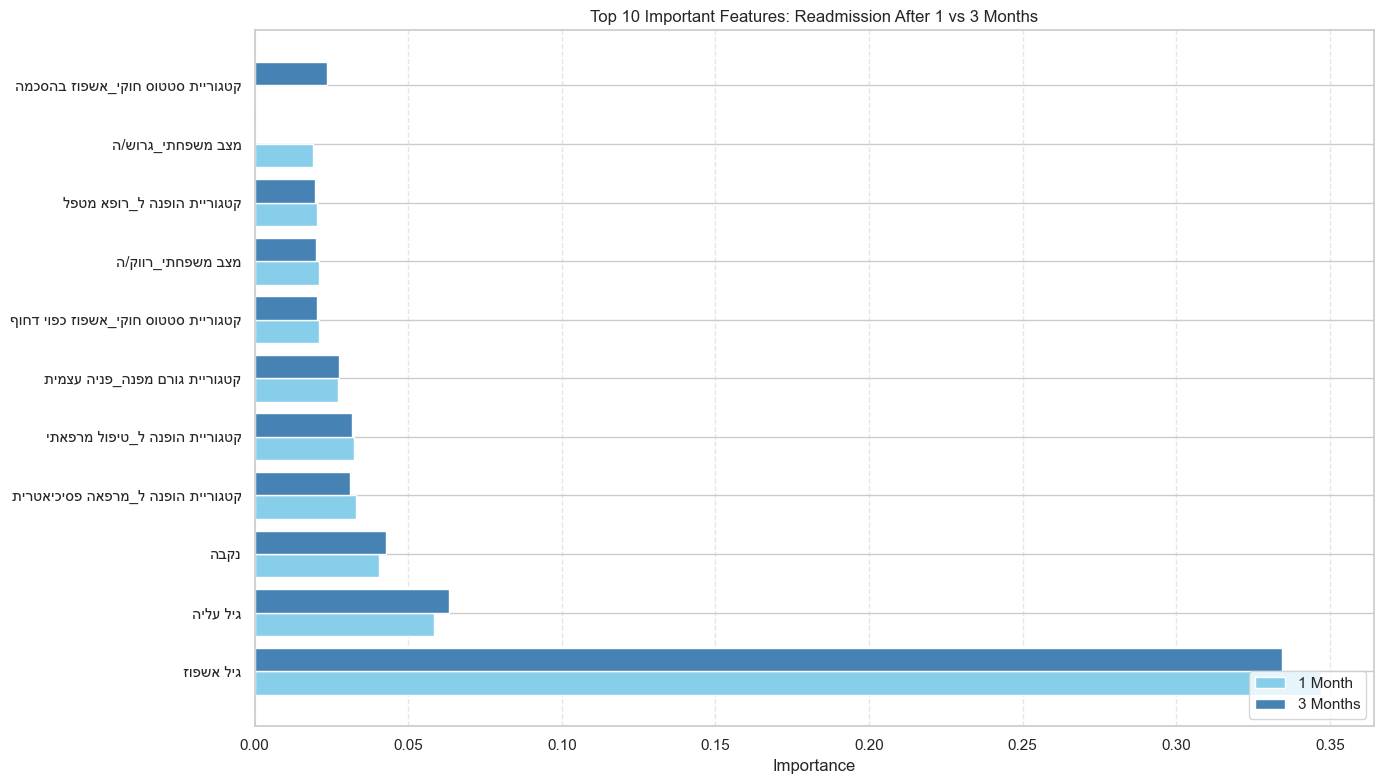

In [37]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import arabic_reshaper
from bidi.algorithm import get_display
from tabulate import tabulate

# 📌 פונקציה לתיקון כיוון עברית (למאפיינים בעברית)
def fix_rtl(text):
    return get_display(arabic_reshaper.reshape(text))

def fix_if_hebrew(text):
    return fix_rtl(text) if any('\u0590' <= c <= '\u05EA' for c in text) else text

# 📌 קריאת קובץ הנתונים
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_only.xlsx"
)
df = pd.read_excel(excel_path)
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# 📌 פונקציה לחישוב חשיבות פיצ'רים
def get_feature_importance(df, target_col):
    X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
    y = df[target_col]
    X.fillna(X.mean(numeric_only=True), inplace=True)
    
    df_balanced = X.copy()
    df_balanced[target_col] = y

    df_majority = df_balanced[df_balanced[target_col] == 0]
    df_minority = df_balanced[df_balanced[target_col] == 1]

    df_minority_oversampled = resample(df_minority, replace=True, n_samples=len(df_majority) // 2, random_state=42)
    df_majority_undersampled = resample(df_majority, replace=False, n_samples=len(df_majority) // 2, random_state=42)
    df_final = pd.concat([df_minority_oversampled, df_majority_undersampled])

    X_bal = df_final.drop(columns=[target_col])
    y_bal = df_final[target_col]

    X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)
    model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)

    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": model.feature_importances_
    }).sort_values("Importance", ascending=False).head(10).reset_index(drop=True)
    return importance_df

# 📌 חישוב עבור חודש ו־3 חודשים
month_df = get_feature_importance(df, "חזר לאשפוז תוך חודש")
three_month_df = get_feature_importance(df, "חזר לאשפוז תוך 3 חודשים")

# 📌 מיזוג תוצאות
merged_df = pd.merge(month_df, three_month_df, on="Feature", how="outer", suffixes=("_1Month", "_3Months"))
merged_df.fillna(0, inplace=True)
merged_df["Feature_Display"] = merged_df["Feature"].apply(fix_if_hebrew)

# 📌 גרף השוואה
plt.figure(figsize=(14, 8))
bar_width = 0.4
indices = np.arange(len(merged_df))

plt.barh(indices - bar_width/2, merged_df["Importance_1Month"], bar_width, label="1 Month", color="skyblue")
plt.barh(indices + bar_width/2, merged_df["Importance_3Months"], bar_width, label="3 Months", color="steelblue")

plt.yticks(indices, merged_df["Feature_Display"])
plt.xlabel("Importance")
plt.title("Top 10 Important Features: Readmission After 1 vs 3 Months")
plt.legend(loc="lower right")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




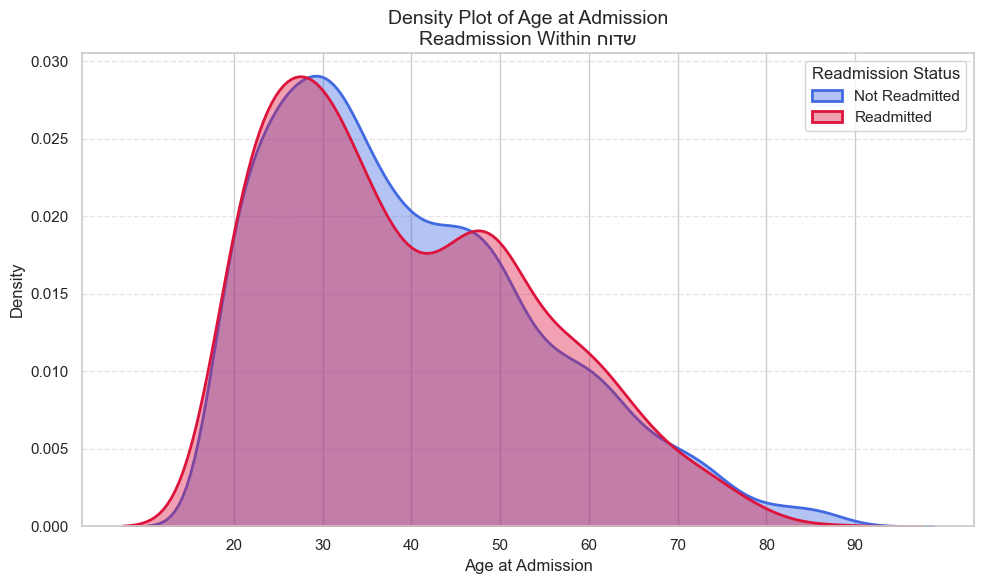


📋 טבלת סיכום - גיל אשפוז מול חזרה תוך חודש:

              מדד               תוצאה
p-value לנורמליות              0.0000
         סוג מבחן Mann-Whitney U Test
        סטטיסטיקה        4153511.0000
  p-value להשוואה              0.6522

🔍 מסקנה:
❌ אין הבדל מובהק בגיל האשפוז בין מי שחזרו לאשפוז תוך חודש לבין מי שלא.


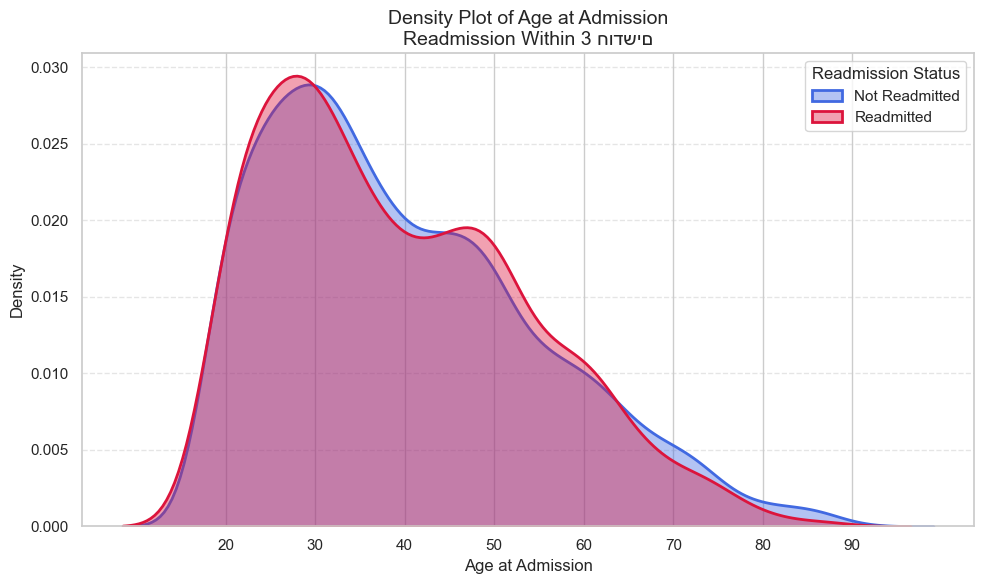


📋 טבלת סיכום - גיל אשפוז מול חזרה תוך 3 חודשים:

              מדד               תוצאה
p-value לנורמליות              0.0000
         סוג מבחן Mann-Whitney U Test
        סטטיסטיקה        5701717.5000
  p-value להשוואה              0.3776

🔍 מסקנה:
❌ אין הבדל מובהק בגיל האשפוז בין מי שחזרו לאשפוז תוך 3 חודשים לבין מי שלא.


In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import os

# 📌 קריאת נתונים
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 המרת גיל אשפוז לערכים ממשיים
min_age = 18
max_age = 94
df['Age'] = df['גיל אשפוז'] * (max_age - min_age) + min_age
df = df.dropna(subset=['Age'])

# 📌 פונקציה שמבצעת את ההשוואה והגרף
def compare_age_by_target(target_col, label):
    group_yes = df[df[target_col] == 1]['Age']
    group_no = df[df[target_col] == 0]['Age']

    # גרף צפיפות
    plt.figure(figsize=(10, 6))
    sns.kdeplot(group_no, label="Not Readmitted", color="royalblue", fill=True, linewidth=2, alpha=0.4)
    sns.kdeplot(group_yes, label="Readmitted", color="crimson", fill=True, linewidth=2, alpha=0.4)
    plt.title(f"Density Plot of Age at Admission\nReadmission Within {label}", fontsize=14)
    plt.xlabel("Age at Admission", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.xticks(np.arange(20, 100, 10))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.legend(title="Readmission Status")
    plt.tight_layout()
    plt.show()

    # נורמליות
    larger_group = group_yes if len(group_yes) > len(group_no) else group_no
    shapiro_stat, shapiro_p = shapiro(larger_group.sample(n=min(500, len(larger_group)), random_state=42))

    # מבחן סטטיסטי
    if shapiro_p >= 0.05:
        test_stat, p_val = ttest_ind(group_yes, group_no, equal_var=False)
        test_name = "Independent T-Test"
    else:
        test_stat, p_val = mannwhitneyu(group_yes, group_no)
        test_name = "Mann-Whitney U Test"

    # טבלה
    summary_table = pd.DataFrame({
        "מדד": ["p-value לנורמליות", "סוג מבחן", "סטטיסטיקה", "p-value להשוואה"],
        "תוצאה": [f"{shapiro_p:.4f}", test_name, f"{test_stat:.4f}", f"{p_val:.4f}"]
    })
    print(f"\n📋 טבלת סיכום - גיל אשפוז מול חזרה תוך {label}:\n")
    print(summary_table.to_string(index=False))

    # מסקנה
    print("\n🔍 מסקנה:")
    if p_val < 0.05:
        print(f"✅ יש הבדל מובהק בגיל האשפוז בין מי שחזרו לאשפוז תוך {label} לבין מי שלא.")
    else:
        print(f"❌ אין הבדל מובהק בגיל האשפוז בין מי שחזרו לאשפוז תוך {label} לבין מי שלא.")

# 📌 הרצה עבור חודש ושלושה חודשים
compare_age_by_target("חזר לאשפוז תוך חודש", "חודש")
compare_age_by_target("חזר לאשפוז תוך 3 חודשים", "3 חודשים")


In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu

# 📁 טוען קובץ מאוזן או לא מאוזן (כאן נתיב לדוגמה)
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 🎯 חישוב גיל ממשי
min_age = 18
max_age = 94
df['Age'] = df['גיל אשפוז'] * (max_age - min_age) + min_age
df = df.dropna(subset=['Age'])

# 📌 פונקציה שמבצעת את כל ההשוואה ומציגה טבלה ברורה
def compare_readmission_age(column_name, label):
    ages_yes = df[df[column_name] == 1]['Age']
    ages_no = df[df[column_name] == 0]['Age']

    # בדיקת נורמליות (מדגם גדול יותר)
    larger_group = ages_yes if len(ages_yes) > len(ages_no) else ages_no
    shapiro_p = shapiro(larger_group.sample(n=min(500, len(larger_group)), random_state=42)).pvalue

    # בחירת מבחן
    if shapiro_p >= 0.05:
        test_stat, p_val = ttest_ind(ages_yes, ages_no, equal_var=False)
        test_used = "Independent T-Test"
    else:
        test_stat, p_val = mannwhitneyu(ages_yes, ages_no)
        test_used = "Mann-Whitney U Test"

    # 📋 טבלה מסודרת
    print(f"\n📊 השוואת גיל בין חוזרים ולא חוזרים ({label}):\n")
    print(f"{'מדד':<30} {'תוצאה'}")
    print("-" * 45)
    print(f"{'ממוצע גיל (חזר)':<30} {ages_yes.mean():.2f}")
    print(f"{'ממוצע גיל (לא חזר)':<30} {ages_no.mean():.2f}")
    print(f"{'סוג מבחן':<30} {test_used}")
    print(f"{'p-value':<30} {p_val:.4f}")
    print("-" * 45)

    # 📌 מסקנה
    print("🔍 מסקנה:")
    if p_val < 0.05:
        print(f"✅ יש הבדל מובהק סטטיסטית בגיל בין מי שחזרו לאשפוז תוך {label} לבין מי שלא.\n")
    else:
        print(f"❌ אין הבדל מובהק בגיל בין מי שחזרו לאשפוז תוך {label} לבין מי שלא.\n")

# 📌 הרצה עבור שתי התקופות
compare_readmission_age("חזר לאשפוז תוך חודש", "חודש")
compare_readmission_age("חזר לאשפוז תוך 3 חודשים", "3 חודשים")



📊 השוואת גיל בין חוזרים ולא חוזרים (חודש):

מדד                            תוצאה
---------------------------------------------
ממוצע גיל (חזר)                39.43
ממוצע גיל (לא חזר)             39.71
סוג מבחן                       Mann-Whitney U Test
p-value                        0.6522
---------------------------------------------
🔍 מסקנה:
❌ אין הבדל מובהק בגיל בין מי שחזרו לאשפוז תוך חודש לבין מי שלא.


📊 השוואת גיל בין חוזרים ולא חוזרים (3 חודשים):

מדד                            תוצאה
---------------------------------------------
ממוצע גיל (חזר)                39.28
ממוצע גיל (לא חזר)             39.80
סוג מבחן                       Mann-Whitney U Test
p-value                        0.3776
---------------------------------------------
🔍 מסקנה:
❌ אין הבדל מובהק בגיל בין מי שחזרו לאשפוז תוך 3 חודשים לבין מי שלא.



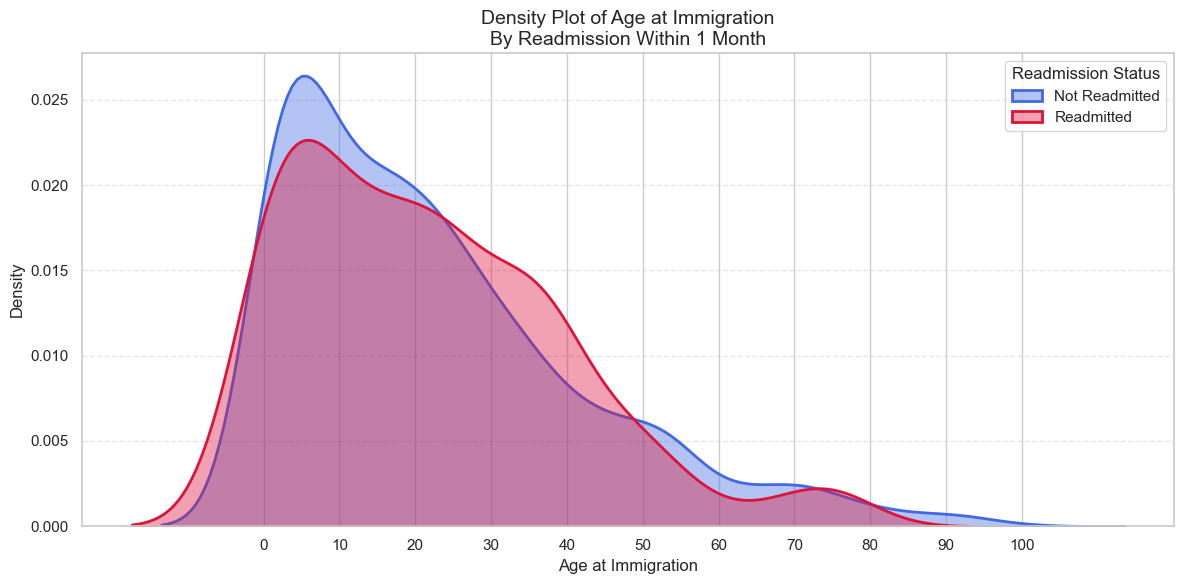

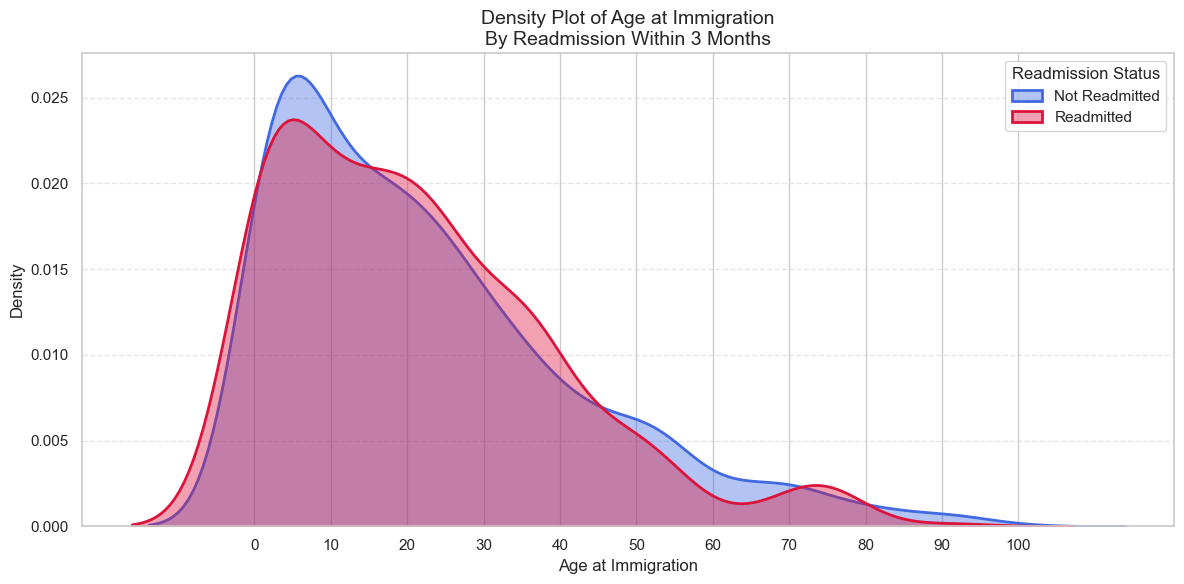


📊 Age at Immigration — Readmission Within 1 Month:

Metric                              Value
--------------------------------------------------
Mean Age (Readmitted)               21.84
Mean Age (Not Readmitted)           22.35
Statistical Test                    Mann-Whitney U Test
p-value                             0.9280
--------------------------------------------------
🔍 Conclusion:
❌ No statistically significant difference in Age at Immigration between groups (within 1 Month).


📊 Age at Immigration — Readmission Within 3 Months:

Metric                              Value
--------------------------------------------------
Mean Age (Readmitted)               21.23
Mean Age (Not Readmitted)           22.60
Statistical Test                    Mann-Whitney U Test
p-value                             0.3468
--------------------------------------------------
🔍 Conclusion:
❌ No statistically significant difference in Age at Immigration between groups (within 3 Months).



In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, ttest_ind, mannwhitneyu
import os

# 📁 Load the file
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# ✅ Convert normalized "גיל עליה" to real age (assume 0–100)
df["AgeAtImmigration"] = pd.to_numeric(df["גיל עליה"], errors="coerce")
df["AgeAtImmigration"] = df["AgeAtImmigration"] * 100
df = df.dropna(subset=["AgeAtImmigration"])

# ✅ Filter valid values
df = df[df["חזר לאשפוז תוך חודש"].isin([0, 1])]
df = df[df["חזר לאשפוז תוך 3 חודשים"].isin([0, 1])]

# 📌 Graph for readmission within 1 month
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df["חזר לאשפוז תוך חודש"] == 0]["AgeAtImmigration"], label="Not Readmitted", color="royalblue", fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(df[df["חזר לאשפוז תוך חודש"] == 1]["AgeAtImmigration"], label="Readmitted", color="crimson", fill=True, alpha=0.4, linewidth=2)
plt.title("Density Plot of Age at Immigration\nBy Readmission Within 1 Month", fontsize=14)
plt.xlabel("Age at Immigration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Readmission Status")
plt.tight_layout()
plt.show()

# 📌 Graph for readmission within 3 months
plt.figure(figsize=(12, 6))
sns.kdeplot(df[df["חזר לאשפוז תוך 3 חודשים"] == 0]["AgeAtImmigration"], label="Not Readmitted", color="royalblue", fill=True, alpha=0.4, linewidth=2)
sns.kdeplot(df[df["חזר לאשפוז תוך 3 חודשים"] == 1]["AgeAtImmigration"], label="Readmitted", color="crimson", fill=True, alpha=0.4, linewidth=2)
plt.title("Density Plot of Age at Immigration\nBy Readmission Within 3 Months", fontsize=14)
plt.xlabel("Age at Immigration", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.xticks(np.arange(0, 101, 10))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Readmission Status")
plt.tight_layout()
plt.show()

# 📌 Function to run comparison
def compare_immigration_age(target_col, label):
    group_yes = df[df[target_col] == 1]["AgeAtImmigration"].dropna()
    group_no = df[df[target_col] == 0]["AgeAtImmigration"].dropna()

    # Normality test
    larger_group = group_yes if len(group_yes) > len(group_no) else group_no
    shapiro_p = shapiro(larger_group.sample(n=min(500, len(larger_group)), random_state=42)).pvalue

    # Statistical test
    if shapiro_p >= 0.05:
        test_stat, p_val = ttest_ind(group_yes, group_no, equal_var=False)
        test_used = "Independent T-Test"
    else:
        test_stat, p_val = mannwhitneyu(group_yes, group_no)
        test_used = "Mann-Whitney U Test"

    # 📋 Print summary
    print(f"\n📊 Age at Immigration — Readmission Within {label}:\n")
    print(f"{'Metric':<35} {'Value'}")
    print("-" * 50)
    print(f"{'Mean Age (Readmitted)':<35} {group_yes.mean():.2f}")
    print(f"{'Mean Age (Not Readmitted)':<35} {group_no.mean():.2f}")
    print(f"{'Statistical Test':<35} {test_used}")
    print(f"{'p-value':<35} {p_val:.4f}")
    print("-" * 50)

    # 🔍 Conclusion
    print("🔍 Conclusion:")
    if p_val < 0.05:
        print(f"✅ Statistically significant difference in Age at Immigration between groups (within {label}).\n")
    else:
        print(f"❌ No statistically significant difference in Age at Immigration between groups (within {label}).\n")

# 📌 Run comparisons
compare_immigration_age("חזר לאשפוז תוך חודש", "1 Month")
compare_immigration_age("חזר לאשפוז תוך 3 חודשים", "3 Months")


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

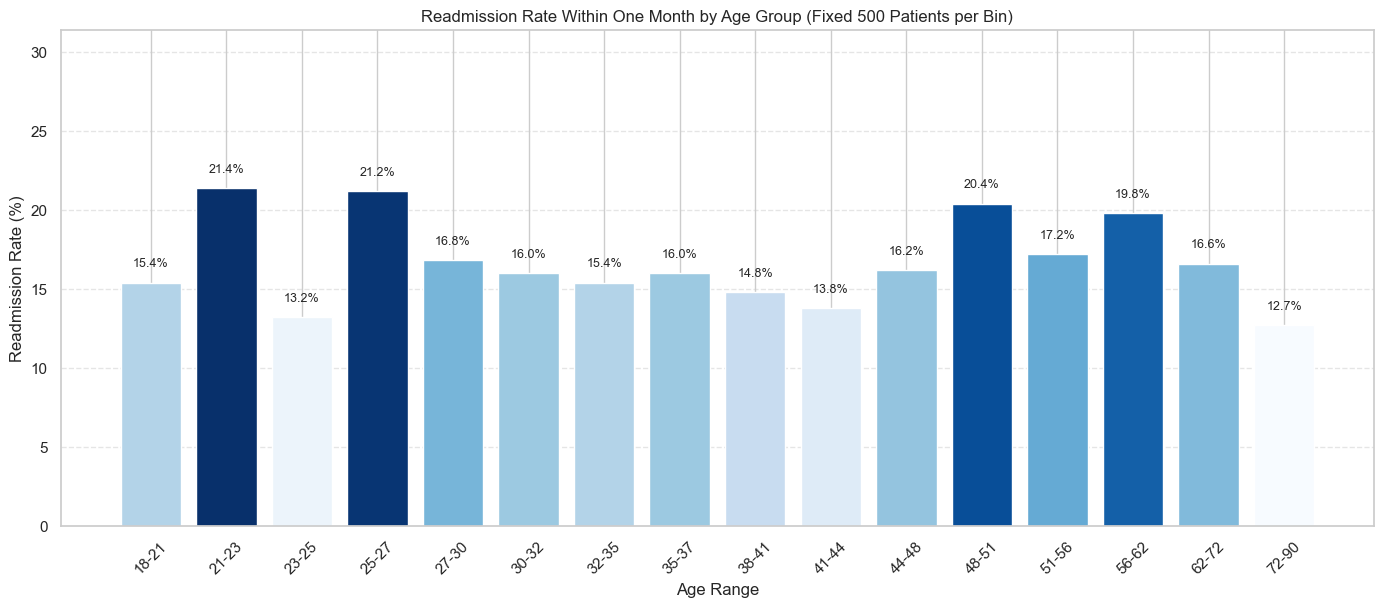

In [52]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]

# 📌 מיון לפי גיל
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 חלוקה לקבוצות לפי מספר קבוע של מטופלים
patients_per_bin = 00
bins = []

for i in range(0, len(df), patients_per_bin):
    group = df.iloc[i:i+patients_per_bin]
    min_age = group["Recovered Age"].min()
    max_age = group["Recovered Age"].max()
    readmission_rate = group["חזר לאשפוז תוך חודש"].mean() * 100
    readmission_rate = round(readmission_rate, 1)
    count = len(group)
    returned_count = group["חזר לאשפוז תוך חודש"].sum()
    
    bins.append({
        "Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": count,
        "Returned Count": returned_count
    })

# 📌 יצירת טבלה סופית
final_table = pd.DataFrame(bins)

# 📌 גרף
plt.figure(figsize=(14, 6))
plt.bar(final_table["Age Range"], final_table["Readmission Rate (%)"], color="cornflowerblue")
plt.title("Readmission Rate Within One Month by Age Group (Fixed 400 Patients per Bin)")
plt.ylabel("Readmission Rate (%)")
plt.xlabel("Age Range")
plt.ylim(0, final_table["Readmission Rate (%)"].max() + 10)

# הוספת תוויות מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    plt.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 📌 הדפסת טבלה מתחת לגרף
print("\n📊 Readmission Rate Within One Month by Age Group (Fixed 400 Patients per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


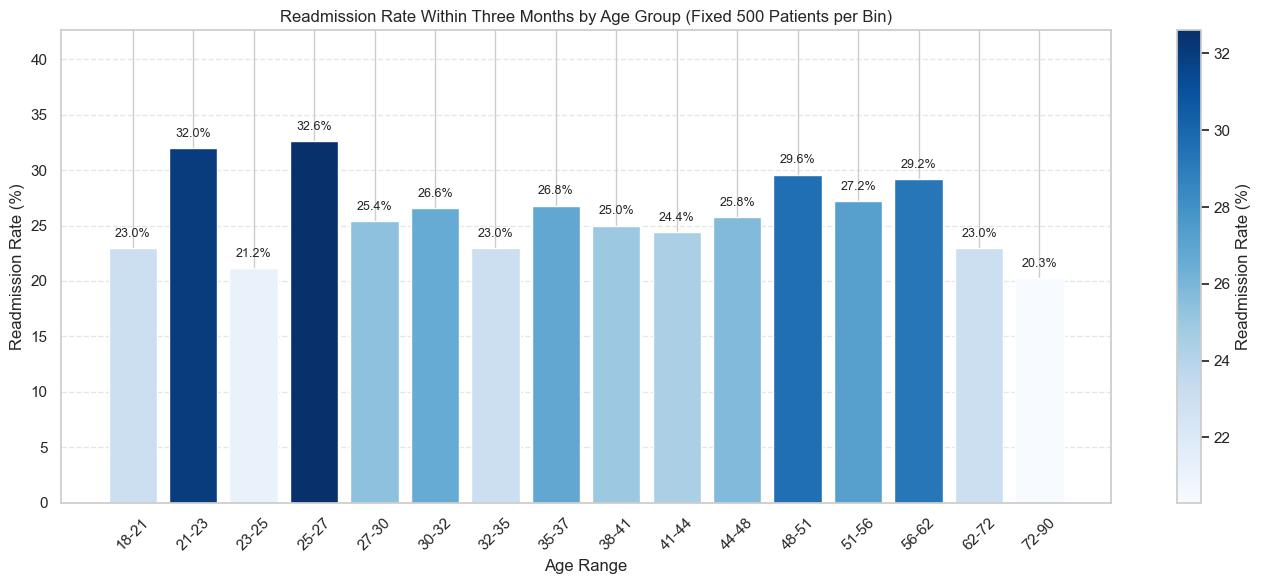


📊 Readmission Rate Within Three Months by Age Group (Fixed 500 Patients per Bin):

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│ Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-21       │                   23   │     500 │              115 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 21-23       │                   32   │     500 │              160 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 23-25       │                   21.2 │     500 │              106 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 25-27       │                   32.6 │     500 │              163 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 27-30       │                   25.4 │     500 │              127 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 30-3

In [58]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]

# 📌 מיון לפי גיל
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 חלוקה לקבוצות לפי מספר קבוע של מטופלים
patients_per_bin = 500
bins = []

for i in range(0, len(df), patients_per_bin):
    group = df.iloc[i:i+patients_per_bin]
    min_age = group["Recovered Age"].min()
    max_age = group["Recovered Age"].max()
    # 📌 שינוי כאן --> חזר לאשפוז תוך 3 חודשים
    readmission_rate = group["חזר לאשפוז תוך 3 חודשים"].mean() * 100
    readmission_rate = round(readmission_rate, 1)
    count = len(group)
    returned_count = group["חזר לאשפוז תוך 3 חודשים"].sum()
    
    bins.append({
        "Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": count,
        "Returned Count": returned_count
    })

# 📌 יצירת טבלה סופית
final_table = pd.DataFrame(bins)

# 📌 נורמליזציה של הערכים לצבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min(), vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('Blues')  # אפשר לשנות ל-'Greens' או 'viridis'
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת גרף עם שני אזורים: אחד לגרף ואחד ל-colorbar
fig, ax = plt.subplots(figsize=(14, 6))

bars = ax.bar(final_table["Age Range"], final_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within Three Months by Age Group (Fixed 500 Patients per Bin)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age Range")
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה מתחת לגרף
print("\n📊 Readmission Rate Within Three Months by Age Group (Fixed 500 Patients per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


Total patients: 1919


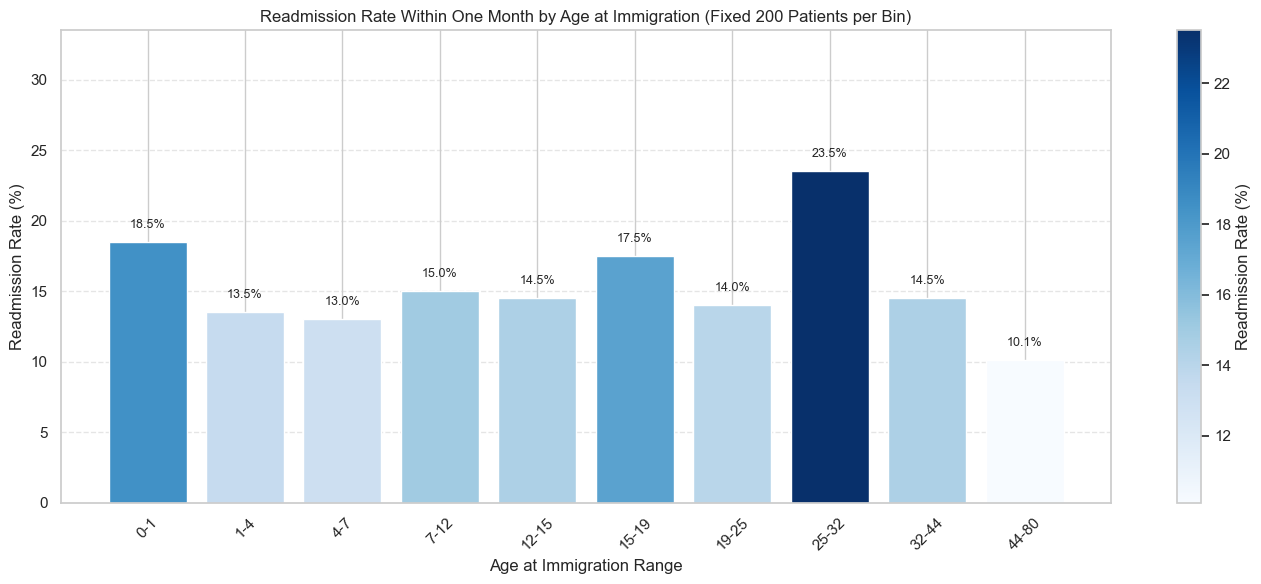

In [69]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה אמיתי מתוך ערך מנורמל
age_min = 0
age_max = 80  # עד גיל 80 בלבד
df = df[df["גיל עליה"].notna()]
df["Recovered Aliyah Age"] = df["גיל עליה"] * (age_max - age_min) + age_min
df = df[df["Recovered Aliyah Age"].notna()]
df["Recovered Aliyah Age"] = df["Recovered Aliyah Age"].astype(int)

# 📌 בדיקה: כמה מטופלים יש סה"כ
total_patients = len(df)
print(f"Total patients: {total_patients}")

# 📌 החלטה: כמה מטופלים לכל bin?
# כלל אצבע: בין 400 ל-500 מטופלים לבין
patients_per_bin = 200  # אפשר לשנות ל־500 אם תרצה

# 📌 חלוקה לקבוצות לפי גיל עליה
df = df.sort_values("Recovered Aliyah Age").reset_index(drop=True)

bins = []

for i in range(0, len(df), patients_per_bin):
    group = df.iloc[i:i+patients_per_bin]
    min_age = group["Recovered Aliyah Age"].min()
    max_age = group["Recovered Aliyah Age"].max()
    readmission_rate = group["חזר לאשפוז תוך חודש"].mean() * 100  # אפשר לשנות ל"חזר לאשפוז תוך 3 חודשים" אם תרצה
    readmission_rate = round(readmission_rate, 1)
    
    bins.append({
        "Aliyah Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate
    })

# 📌 יצירת טבלה סופית
aliyah_table = pd.DataFrame(bins)

# 📌 נורמליזציה לצבעים
norm = colors.Normalize(vmin=aliyah_table["Readmission Rate (%)"].min(), vmax=aliyah_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('Blues')  # אפשר להחליף ל-'Greens' או 'viridis'
bar_colors = cmap(norm(aliyah_table["Readmission Rate (%)"]))

# 📌 גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(aliyah_table["Aliyah Age Range"], aliyah_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within One Month by Age at Immigration (Fixed 200 Patients per Bin)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age at Immigration Range")
ax.set_ylim(0, aliyah_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(aliyah_table["Aliyah Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל כל עמודה
for i, value in enumerate(aliyah_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת סרגל צבעים
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()


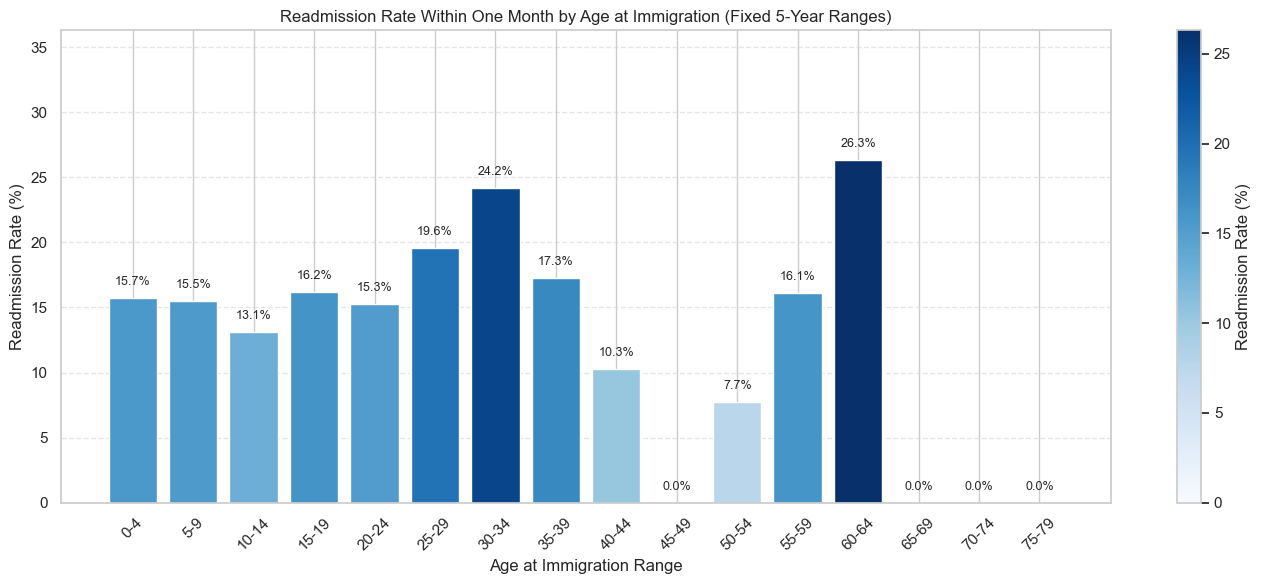

In [68]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה אמיתי מתוך ערך מנורמל
age_min = 0
age_max = 80  # עד גיל 80 בלבד
df = df[df["גיל עליה"].notna()]
df["Recovered Aliyah Age"] = df["גיל עליה"] * (age_max - age_min) + age_min
df = df[df["Recovered Aliyah Age"].notna()]
df["Recovered Aliyah Age"] = df["Recovered Aliyah Age"].astype(int)

# 📌 יצירת טווחים קבועים של 5 שנים
bins = list(range(0, 85, 5))  # 0,5,10,...80
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df["Aliyah Age Group"] = pd.cut(df["Recovered Aliyah Age"], bins=bins, labels=labels, right=False)

# 📌 חישוב אחוז חזרה לכל טווח גיל
aliyah_table = df.groupby("Aliyah Age Group")["חזר לאשפוז תוך חודש"].mean().reset_index()
aliyah_table["Readmission Rate (%)"] = (aliyah_table["חזר לאשפוז תוך חודש"] * 100).round(1)
aliyah_table = aliyah_table.drop(columns=["חזר לאשפוז תוך חודש"])

# 📌 נורמליזציה לצבעים
norm = colors.Normalize(vmin=aliyah_table["Readmission Rate (%)"].min(), vmax=aliyah_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('Blues')  # אפשר גם viridis, Greens
bar_colors = cmap(norm(aliyah_table["Readmission Rate (%)"]))

# 📌 גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(aliyah_table["Aliyah Age Group"], aliyah_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within One Month by Age at Immigration (Fixed 5-Year Ranges)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age at Immigration Range")
ax.set_ylim(0, aliyah_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(aliyah_table["Aliyah Age Group"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל כל עמודה
for i, value in enumerate(aliyah_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת סרגל צבעים
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()


C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\3190786750.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('BuGn')  # 👈 שינוי כאן ל-BuGn
C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\3190786750.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aliyah_table["Aliyah Age Group"], rotation=45)


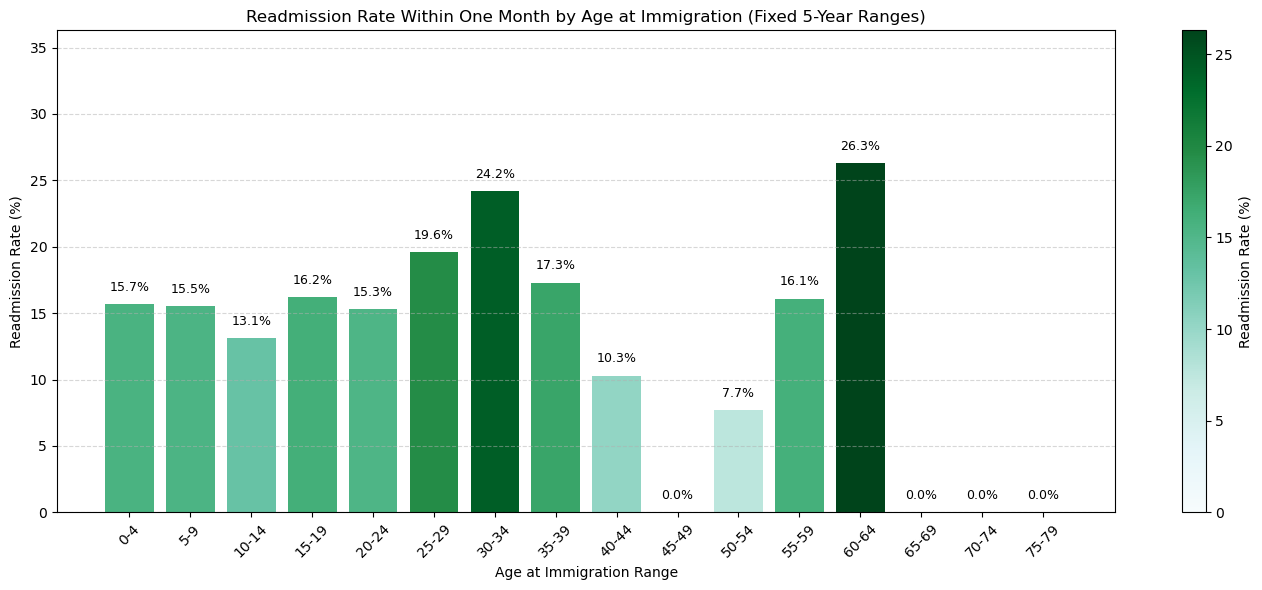


📊 Readmission Rate Within One Month by Aliyah Age Group (Fixed 5-Year Ranges):

╒════════════════════╤════════════════════════╕
│ Aliyah Age Group   │   Readmission Rate (%) │
╞════════════════════╪════════════════════════╡
│ 0-4                │                   15.7 │
├────────────────────┼────────────────────────┤
│ 5-9                │                   15.5 │
├────────────────────┼────────────────────────┤
│ 10-14              │                   13.1 │
├────────────────────┼────────────────────────┤
│ 15-19              │                   16.2 │
├────────────────────┼────────────────────────┤
│ 20-24              │                   15.3 │
├────────────────────┼────────────────────────┤
│ 25-29              │                   19.6 │
├────────────────────┼────────────────────────┤
│ 30-34              │                   24.2 │
├────────────────────┼────────────────────────┤
│ 35-39              │                   17.3 │
├────────────────────┼────────────────────────┤
│ 40-44

In [10]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate


# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה אמיתי מתוך ערך מנורמל
age_min = 0
age_max = 80  # עד גיל 80 בלבד
df = df[df["גיל עליה"].notna()]
df["Recovered Aliyah Age"] = df["גיל עליה"] * (age_max - age_min) + age_min
df = df[df["Recovered Aliyah Age"].notna()]
df["Recovered Aliyah Age"] = df["Recovered Aliyah Age"].astype(int)

# 📌 יצירת טווחים קבועים של 5 שנים
bins = list(range(0, 85, 5))  # 0,5,10,...80
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df["Aliyah Age Group"] = pd.cut(df["Recovered Aliyah Age"], bins=bins, labels=labels, right=False)

# 📌 חישוב אחוז חזרה לכל טווח גיל
aliyah_table = df.groupby("Aliyah Age Group")["חזר לאשפוז תוך חודש"].mean().reset_index()
aliyah_table["Readmission Rate (%)"] = (aliyah_table["חזר לאשפוז תוך חודש"] * 100).round(1)
aliyah_table = aliyah_table.drop(columns=["חזר לאשפוז תוך חודש"])

# 📌 נורמליזציה לצבעים
norm = colors.Normalize(vmin=aliyah_table["Readmission Rate (%)"].min(), vmax=aliyah_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('BuGn')  # 👈 שינוי כאן ל-BuGn
bar_colors = cmap(norm(aliyah_table["Readmission Rate (%)"]))

# 📌 גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(aliyah_table["Aliyah Age Group"], aliyah_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within One Month by Age at Immigration (Fixed 5-Year Ranges)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age at Immigration Range")
ax.set_ylim(0, aliyah_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(aliyah_table["Aliyah Age Group"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל כל עמודה
for i, value in enumerate(aliyah_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת סרגל צבעים
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()
print("\n📊 Readmission Rate Within One Month by Aliyah Age Group (Fixed 5-Year Ranges):\n")
print(tabulate(aliyah_table, headers="keys", tablefmt="fancy_grid", showindex=False))

C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\3141580542.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('BuGn')  # אותו סגנון ירוק
C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\3141580542.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aliyah_table_3months["Aliyah Age Group"], rotation=45)


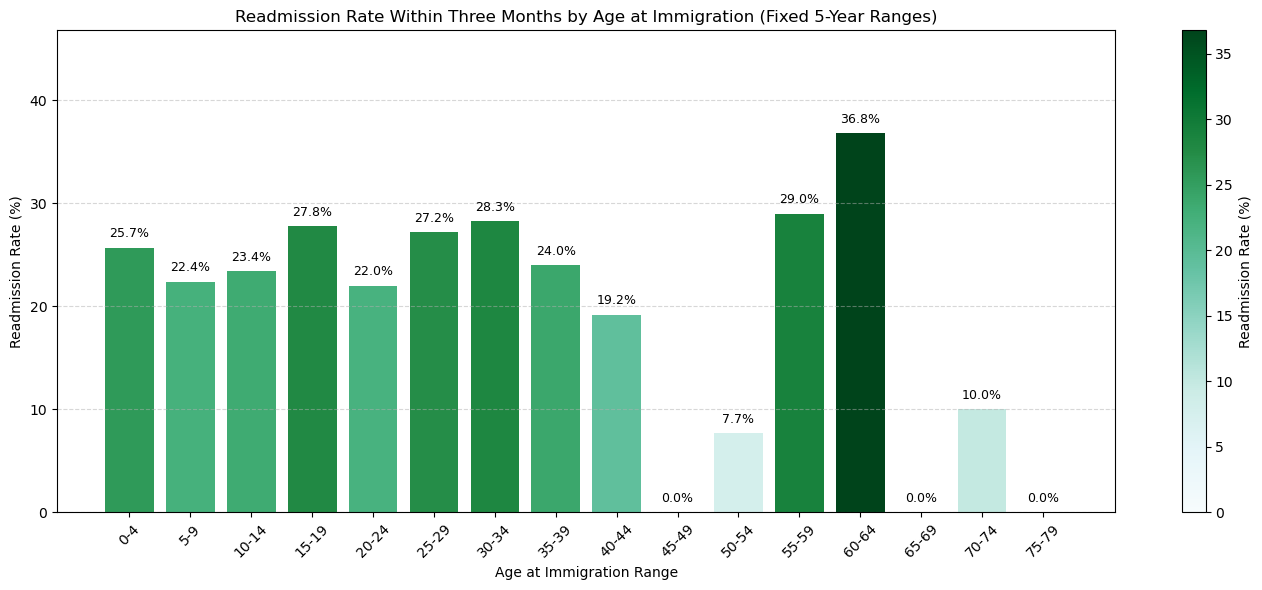


📊 Readmission Rate Within Three Months by Aliyah Age Group (Fixed 5-Year Ranges):

╒════════════════════╤════════════════════════╕
│ Aliyah Age Group   │   Readmission Rate (%) │
╞════════════════════╪════════════════════════╡
│ 0-4                │                   25.7 │
├────────────────────┼────────────────────────┤
│ 5-9                │                   22.4 │
├────────────────────┼────────────────────────┤
│ 10-14              │                   23.4 │
├────────────────────┼────────────────────────┤
│ 15-19              │                   27.8 │
├────────────────────┼────────────────────────┤
│ 20-24              │                   22   │
├────────────────────┼────────────────────────┤
│ 25-29              │                   27.2 │
├────────────────────┼────────────────────────┤
│ 30-34              │                   28.3 │
├────────────────────┼────────────────────────┤
│ 35-39              │                   24   │
├────────────────────┼────────────────────────┤
│ 40

In [11]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה אמיתי מתוך ערך מנורמל
age_min = 0
age_max = 80
df = df[df["גיל עליה"].notna()]
df["Recovered Aliyah Age"] = df["גיל עליה"] * (age_max - age_min) + age_min
df = df[df["Recovered Aliyah Age"].notna()]
df["Recovered Aliyah Age"] = df["Recovered Aliyah Age"].astype(int)

# 📌 יצירת טווחים קבועים של 5 שנים
bins = list(range(0, 85, 5))  # 0,5,10,...80
labels = [f"{bins[i]}-{bins[i+1]-1}" for i in range(len(bins)-1)]
df["Aliyah Age Group"] = pd.cut(df["Recovered Aliyah Age"], bins=bins, labels=labels, right=False)

# 📌 חישוב אחוז חזרה לכל טווח גיל - הפעם תוך 3 חודשים
aliyah_table_3months = df.groupby("Aliyah Age Group")["חזר לאשפוז תוך 3 חודשים"].mean().reset_index()
aliyah_table_3months["Readmission Rate (%)"] = (aliyah_table_3months["חזר לאשפוז תוך 3 חודשים"] * 100).round(1)
aliyah_table_3months = aliyah_table_3months.drop(columns=["חזר לאשפוז תוך 3 חודשים"])

# 📌 נורמליזציה לצבעים
norm = colors.Normalize(vmin=aliyah_table_3months["Readmission Rate (%)"].min(), vmax=aliyah_table_3months["Readmission Rate (%)"].max())
cmap = cm.get_cmap('BuGn')  # אותו סגנון ירוק
bar_colors = cmap(norm(aliyah_table_3months["Readmission Rate (%)"]))

# 📌 גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(aliyah_table_3months["Aliyah Age Group"], aliyah_table_3months["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within Three Months by Age at Immigration (Fixed 5-Year Ranges)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age at Immigration Range")
ax.set_ylim(0, aliyah_table_3months["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(aliyah_table_3months["Aliyah Age Group"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל כל עמודה
for i, value in enumerate(aliyah_table_3months["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת סרגל צבעים
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה
print("\n📊 Readmission Rate Within Three Months by Aliyah Age Group (Fixed 5-Year Ranges):\n")
print(tabulate(aliyah_table_3months, headers="keys", tablefmt="fancy_grid", showindex=False))


C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\952192734.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('BuGn')  # ירוק נעים
C:\Users\hadma\AppData\Local\Temp\ipykernel_30640\952192734.py:64: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(aliyah_table_fixed_patients["Aliyah Age Range"], rotation=45)


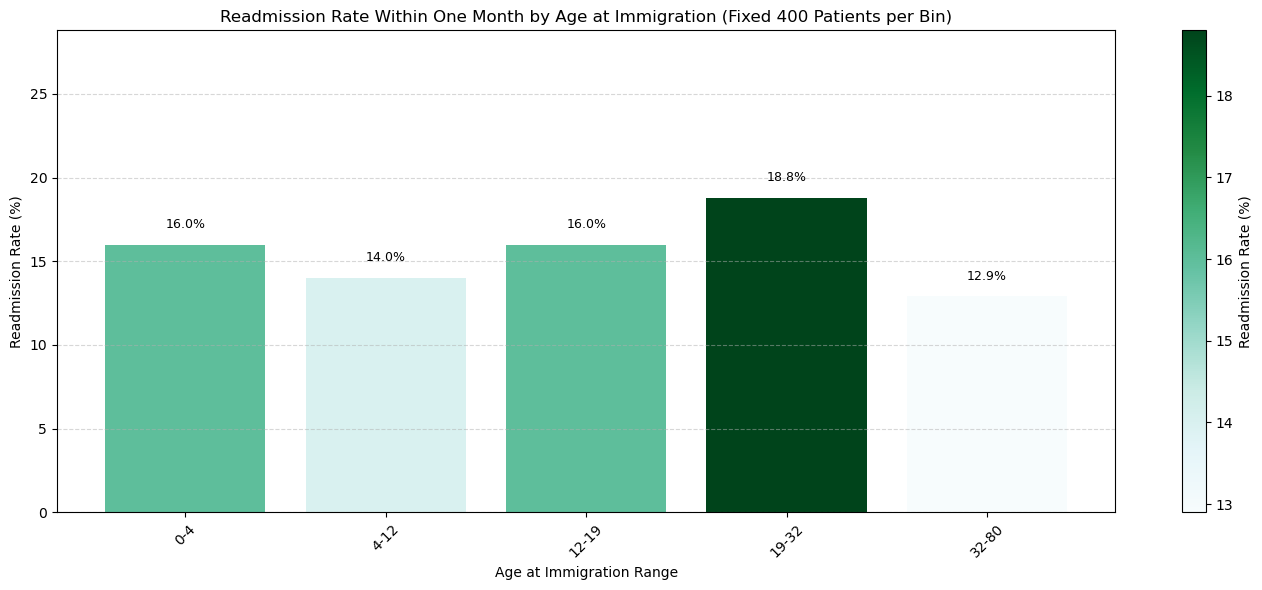


📊 Readmission Rate Within One Month by Aliyah Age Group (Fixed 400 Patients per Bin):

╒════════════════════╤════════════════════════╤═════════╤══════════════════╕
│ Aliyah Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞════════════════════╪════════════════════════╪═════════╪══════════════════╡
│ 0-4                │                   16   │     400 │               64 │
├────────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 4-12               │                   14   │     400 │               56 │
├────────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 12-19              │                   16   │     400 │               64 │
├────────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 19-32              │                   18.8 │     400 │               75 │
├────────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 32-80              │                   12.9 │     319 │        

In [12]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה אמיתי מתוך ערך מנורמל
age_min = 0
age_max = 80  # גיל עליה בטווח 0-80
df = df[df["גיל עליה"].notna()]
df["Recovered Aliyah Age"] = df["גיל עליה"] * (age_max - age_min) + age_min
df = df[df["Recovered Aliyah Age"].notna()]
df["Recovered Aliyah Age"] = df["Recovered Aliyah Age"].astype(int)

# 📌 מיון לפי גיל עליה
df = df.sort_values("Recovered Aliyah Age").reset_index(drop=True)

# 📌 חלוקה לקבוצות לפי 400 מטופלים
patients_per_bin = 400
bins = []

for i in range(0, len(df), patients_per_bin):
    group = df.iloc[i:i+patients_per_bin]
    min_age = group["Recovered Aliyah Age"].min()
    max_age = group["Recovered Aliyah Age"].max()
    readmission_rate = group["חזר לאשפוז תוך חודש"].mean() * 100
    readmission_rate = round(readmission_rate, 1)
    count = len(group)
    returned_count = group["חזר לאשפוז תוך חודש"].sum()
    
    bins.append({
        "Aliyah Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": count,
        "Returned Count": returned_count
    })

# 📌 יצירת טבלה סופית
aliyah_table_fixed_patients = pd.DataFrame(bins)

# 📌 נורמליזציה לצבעים
norm = colors.Normalize(vmin=aliyah_table_fixed_patients["Readmission Rate (%)"].min(), vmax=aliyah_table_fixed_patients["Readmission Rate (%)"].max())
cmap = cm.get_cmap('BuGn')  # ירוק נעים
bar_colors = cmap(norm(aliyah_table_fixed_patients["Readmission Rate (%)"]))

# 📌 יצירת גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(aliyah_table_fixed_patients["Aliyah Age Range"], aliyah_table_fixed_patients["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within One Month by Age at Immigration (Fixed 400 Patients per Bin)")
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age at Immigration Range")
ax.set_ylim(0, aliyah_table_fixed_patients["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(aliyah_table_fixed_patients["Aliyah Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 הוספת תוויות מעל כל עמודה
for i, value in enumerate(aliyah_table_fixed_patients["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=9)

# 📌 הוספת סרגל צבעים
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה מתחת לגרף
print("\n📊 Readmission Rate Within One Month by Aliyah Age Group (Fixed 400 Patients per Bin):\n")
print(tabulate(aliyah_table_fixed_patients, headers="keys", tablefmt="fancy_grid", showindex=False))


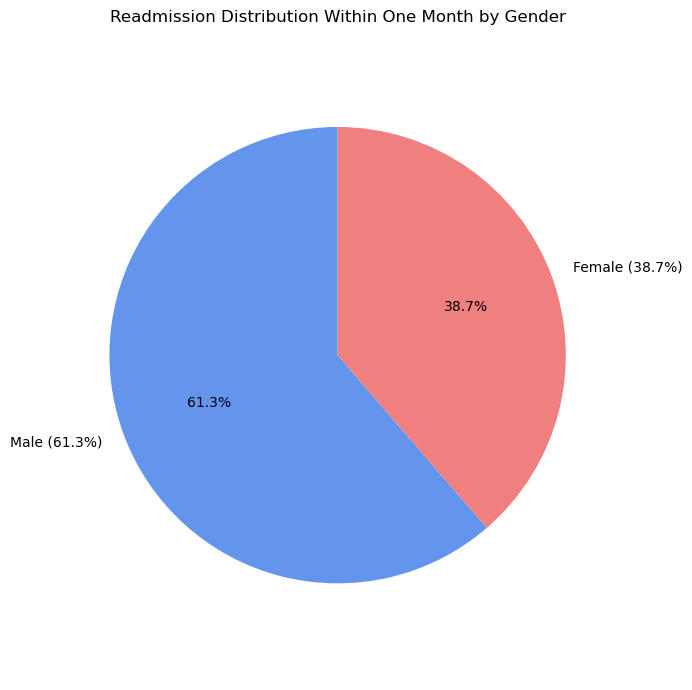


📊 Readmission Distribution Within One Month by Gender:

╒══════════╤══════════════════════════╤══════════════════╕
│ Gender   │   Number of Readmissions │   Percentage (%) │
╞══════════╪══════════════════════════╪══════════════════╡
│ Male     │                      798 │             61.3 │
├──────────┼──────────────────────────┼──────────────────┤
│ Female   │                      503 │             38.7 │
╘══════════╧══════════════════════════╧══════════════════╛


In [27]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 תרגום עמודת מגדר
df = df[df["נקבה"].notna()]
df["Gender"] = df["נקבה"].apply(lambda x: "Female" if x == 1 else "Male")

# 📌 סינון אשפוזים שחזרו תוך חודש
readmitted_df = df[df["חזר לאשפוז תוך חודש"] == 1]

# 📌 ספירת מספר אשפוזים שחזרו לפי מגדר
readmitted_counts = readmitted_df["Gender"].value_counts().reset_index()
readmitted_counts.columns = ["Gender", "Number of Readmissions"]

# 📌 חישוב אחוזים
total_readmissions = readmitted_counts["Number of Readmissions"].sum()
readmitted_counts["Percentage (%)"] = (readmitted_counts["Number of Readmissions"] / total_readmissions * 100).round(1)

# 📌 הכנה לצבעים קבועים
color_mapping = {
    "Female": "lightcoral",
    "Male": "cornflowerblue"
}
colors = [color_mapping[gender] for gender in readmitted_counts["Gender"]]

# 📌 גרף פאי
fig, ax = plt.subplots(figsize=(7, 7))
ax.pie(
    readmitted_counts["Number of Readmissions"],
    labels=[f"{gender} ({perc:.1f}%)" for gender, perc in zip(readmitted_counts["Gender"], readmitted_counts["Percentage (%)"])],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors
)
ax.set_title("Readmission Distribution Within One Month by Gender")
plt.axis('equal')
plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה
print("\n📊 Readmission Distribution Within One Month by Gender:\n")
print(tabulate(readmitted_counts, headers="keys", tablefmt="fancy_grid", showindex=False))


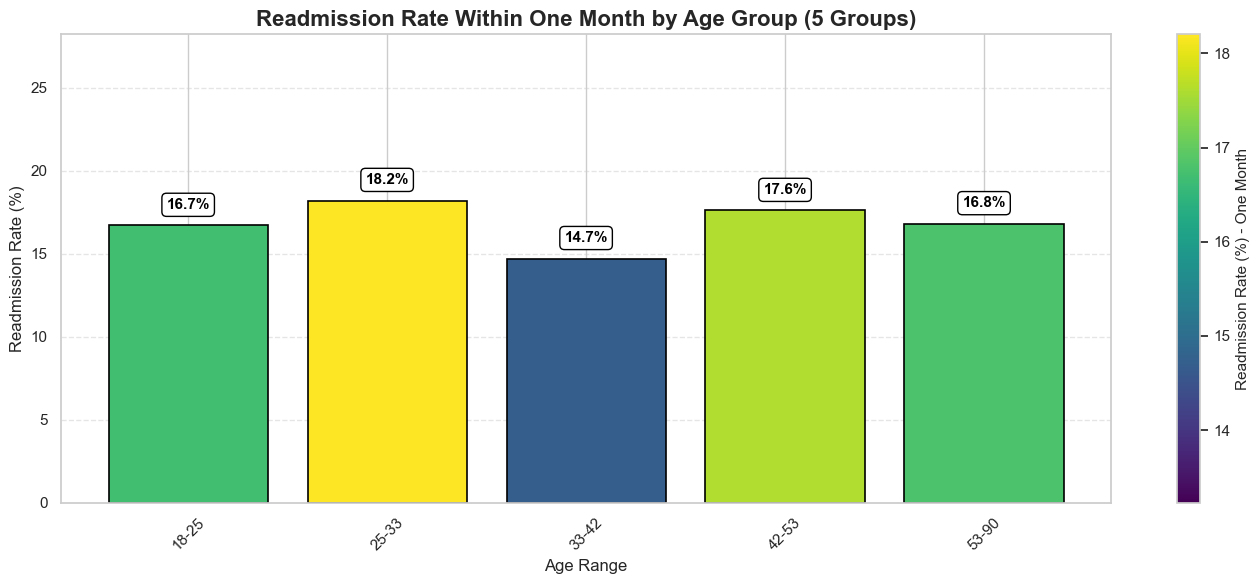


📊 Final Table - Readmission Rate Within One Month by Age Group:

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│  Age Range  │  Readmission Rate (%)  │  Count  │  Returned Count  │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│    18-25    │          16.7          │  1547   │       394        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    25-33    │          18.2          │  1547   │       434        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    33-42    │          14.7          │  1547   │       381        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    42-53    │          17.6          │  1547   │       428        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    53-90    │          16.8          │  1549   │       385        │
╘═════════════╧════════════════════════╧═════════╧══════════════════╛


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 חלוקה ל־5 קבוצות שוות
n_groups = 5
group_size = len(df) // n_groups
bins = []

for i in range(n_groups):
    group = df.iloc[i*group_size:(i+1)*group_size if i < n_groups-1 else len(df)]
    min_g = group["Recovered Age"].min()
    max_g = group["Recovered Age"].max()
    rate = round(group["חזר לאשפוז תוך חודש"].mean() * 100, 1)

    
    bins.append({
        "Age Range": f"{min_g}-{max_g}",
        "Readmission Rate (%)": rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך 3 חודשים"].sum()
    })

final_table = pd.DataFrame(bins)

# 📌 הגדרת צבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min() * 0.9,
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('viridis', 256)
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת הגרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(
    final_table["Age Range"],
    final_table["Readmission Rate (%)"],
    color=bar_colors,
    edgecolor='black',
    linewidth=1.2
)

ax.set_title("Readmission Rate Within One Month by Age Group (5 Groups)", fontsize=16, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)", fontsize=12)
ax.set_xlabel("Age Range", fontsize=12)
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Age Range"], rotation=45, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות על כל עמודה – עם תיקון שקיפות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(
        i, value + 1,
        f"{value:.1f}%",
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='black',  # תמיד שחור
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            boxstyle='round,pad=0.3',
            alpha=1  # לא שקוף בכלל
        ),
        zorder=10
    )


# 📌 Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%) - One Month', fontsize=11)


plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה מעוצבת וברורה
print("\n📊 Final Table - Readmission Rate Within One Month by Age Group:\n")
print(tabulate(
    final_table,
    headers='keys',
    tablefmt='fancy_grid',  
    showindex=False,
    numalign='center',
    stralign='center'
))

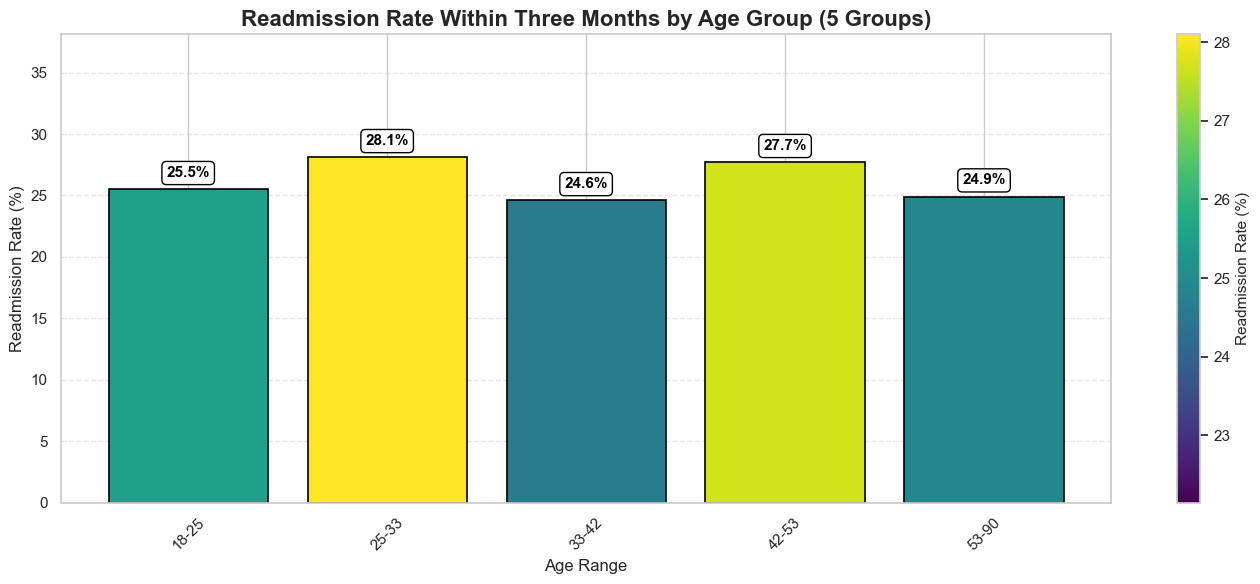


📊 Final Table - Readmission Rate Within Three Months by Age Group:

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│  Age Range  │  Readmission Rate (%)  │  Count  │  Returned Count  │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│    18-25    │          25.5          │  1547   │       394        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    25-33    │          28.1          │  1547   │       434        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    33-42    │          24.6          │  1547   │       381        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    42-53    │          27.7          │  1547   │       428        │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│    53-90    │          24.9          │  1549   │       385        │
╘═════════════╧════════════════════════╧═════════╧══════════════════╛


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 חלוקה ל־5 קבוצות שוות
n_groups = 5
group_size = len(df) // n_groups
bins = []

for i in range(n_groups):
    group = df.iloc[i*group_size:(i+1)*group_size if i < n_groups-1 else len(df)]
    min_g = group["Recovered Age"].min()
    max_g = group["Recovered Age"].max()
    rate = round(group["חזר לאשפוז תוך 3 חודשים"].mean() * 100, 1)
    
    bins.append({
        "Age Range": f"{min_g}-{max_g}",
        "Readmission Rate (%)": rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך 3 חודשים"].sum()
    })

final_table = pd.DataFrame(bins)

# 📌 הגדרת צבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min() * 0.9,
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('viridis', 256)
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת הגרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(
    final_table["Age Range"],
    final_table["Readmission Rate (%)"],
    color=bar_colors,
    edgecolor='black',
    linewidth=1.2
)

ax.set_title("Readmission Rate Within Three Months by Age Group (5 Groups)", fontsize=16, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)", fontsize=12)
ax.set_xlabel("Age Range", fontsize=12)
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Age Range"], rotation=45, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות על כל עמודה – עם תיקון שקיפות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(
        i, value + 1,
        f"{value:.1f}%",
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='black',  # תמיד שחור
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            boxstyle='round,pad=0.3',
            alpha=1  # לא שקוף בכלל
        ),
        zorder=10
    )


# 📌 Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%)', fontsize=11)

plt.tight_layout()
plt.show()

# 📌 הדפסת טבלה עם מסגרת מקצועית
print("\n📊 Final Table - Readmission Rate Within Three Months by Age Group:\n")
print(tabulate(
    final_table,
    headers='keys',
    tablefmt='fancy_grid',   # מסגרת עבה ויפה
    showindex=False,
    numalign='center',
    stralign='center'
))

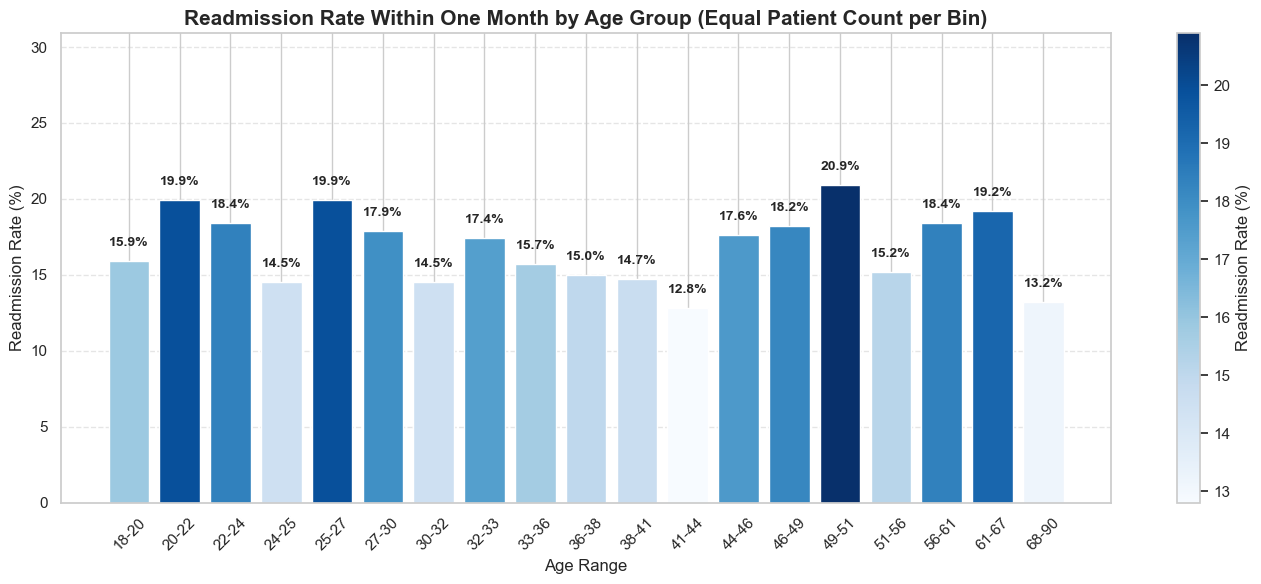


📊 Readmission Rate Within One Month by Age Group (Equal Patient Count per Bin):

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│ Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-20       │                   15.9 │     408 │               65 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 20-22       │                   19.9 │     407 │               81 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 22-24       │                   18.4 │     407 │               75 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 24-25       │                   14.5 │     407 │               59 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 25-27       │                   19.9 │     407 │               81 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 27-30 

In [22]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 קביעת מספר קבוצות
patients_per_bin = 400
n_bins = len(df) // patients_per_bin

# 📌 חלוקה שווה לפי כמות מטופלים
df['Bin'] = pd.qcut(df['Recovered Age'].rank(method='first'), q=n_bins, labels=False)

bins = []
for bin_id in sorted(df['Bin'].unique()):
    group = df[df['Bin'] == bin_id]
    min_age = group["Recovered Age"].min()
    max_age = group["Recovered Age"].max()
    readmission_rate = round(group["חזר לאשפוז תוך חודש"].mean() * 100, 1)
    bins.append({
        "Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך חודש"].sum()
    })

# 📌 יצירת טבלה סופית
final_table = pd.DataFrame(bins)

# 📌 נורמליזציה של הערכים לצבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min(),
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('Blues')
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(final_table["Age Range"], final_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within One Month by Age Group (Equal Patient Count per Bin)", fontsize=15, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age Range")
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=10, fontweight='bold')

# 📌 colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 טבלה עם עיצוב
print("\n📊 Readmission Rate Within One Month by Age Group (Equal Patient Count per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


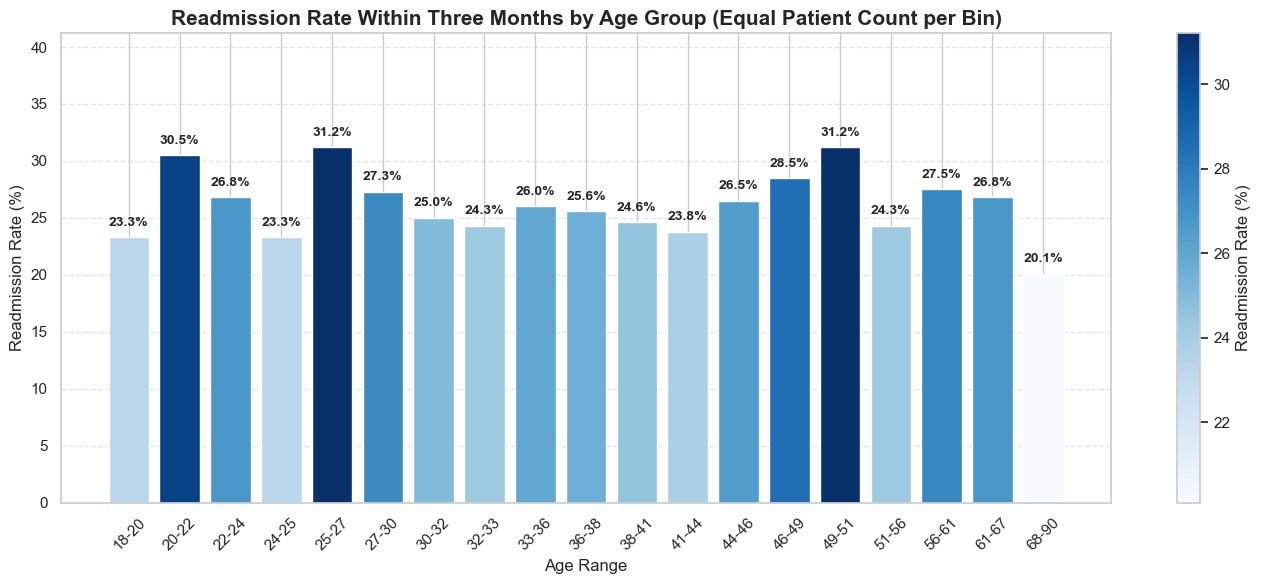


📊 Readmission Rate Within Three Months by Age Group (Equal Patient Count per Bin):

╒═════════════╤════════════════════════╤═════════╤══════════════════╕
│ Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞═════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-20       │                   23.3 │     408 │               95 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 20-22       │                   30.5 │     407 │              124 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 22-24       │                   26.8 │     407 │              109 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 24-25       │                   23.3 │     407 │               95 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 25-27       │                   31.2 │     407 │              127 │
├─────────────┼────────────────────────┼─────────┼──────────────────┤
│ 27-

In [23]:
# 📌 ייבוא ספריות
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל אמיתי מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Age"] = df["גיל אשפוז"] * (max_age - min_age) + min_age
df = df[df["Recovered Age"].notna()]
df["Recovered Age"] = df["Recovered Age"].astype(int)
df = df[df["Recovered Age"] >= 18]
df = df.sort_values("Recovered Age").reset_index(drop=True)

# 📌 קביעת מספר קבוצות
patients_per_bin = 400
n_bins = len(df) // patients_per_bin

# 📌 חלוקה שווה לפי כמות מטופלים
df['Bin'] = pd.qcut(df['Recovered Age'].rank(method='first'), q=n_bins, labels=False)

bins = []
for bin_id in sorted(df['Bin'].unique()):
    group = df[df['Bin'] == bin_id]
    min_age = group["Recovered Age"].min()
    max_age = group["Recovered Age"].max()
    readmission_rate = round(group["חזר לאשפוז תוך 3 חודשים"].mean() * 100, 1)
    bins.append({
        "Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך 3 חודשים"].sum()
    })

# 📌 יצירת טבלה סופית
final_table = pd.DataFrame(bins)

# 📌 נורמליזציה של הערכים לצבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min(),
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('Blues')
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(final_table["Age Range"], final_table["Readmission Rate (%)"], color=bar_colors)

ax.set_title("Readmission Rate Within Three Months by Age Group (Equal Patient Count per Bin)", fontsize=15, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Age Range")
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=10, fontweight='bold')

# 📌 colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 טבלה עם עיצוב
print("\n📊 Readmission Rate Within Three Months by Age Group (Equal Patient Count per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


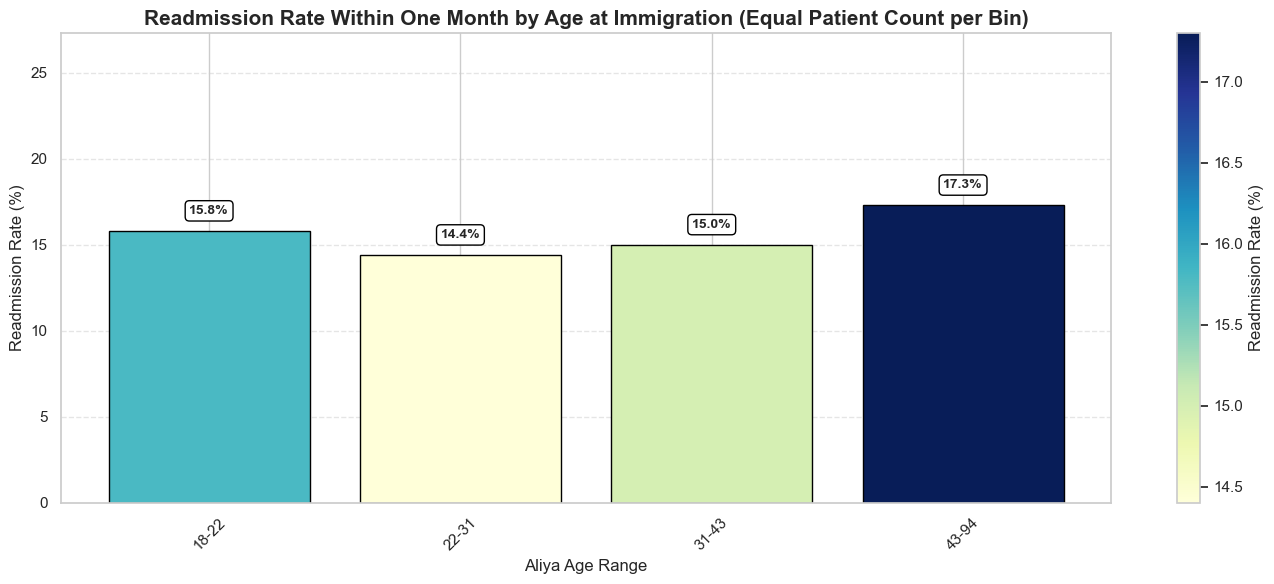


📊 Readmission Rate Within One Month by Aliya Age Group (Equal Patient Count per Bin):

╒═══════════════════╤════════════════════════╤═════════╤══════════════════╕
│ Aliya Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞═══════════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-22             │                   15.8 │     480 │               76 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 22-31             │                   14.4 │     480 │               69 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 31-43             │                   15   │     479 │               72 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 43-94             │                   17.3 │     480 │               83 │
╘═══════════════════╧════════════════════════╧═════════╧══════════════════╛


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עלייה מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Aliya Age"] = df["גיל עליה"] * (max_age - min_age) + min_age
df = df[df["Recovered Aliya Age"].notna()]
df["Recovered Aliya Age"] = df["Recovered Aliya Age"].astype(int)
df = df[df["Recovered Aliya Age"] >= 18]
df = df.sort_values("Recovered Aliya Age").reset_index(drop=True)

# 📌 הגדרת קבוצות לפי כמות שווה של מטופלים
patients_per_bin = 400
n_bins = len(df) // patients_per_bin
df['Bin'] = pd.qcut(df['Recovered Aliya Age'].rank(method='first'), q=n_bins, labels=False)

# 📌 חישוב מדדים לקבוצות
bins = []
for bin_id in sorted(df['Bin'].unique()):
    group = df[df['Bin'] == bin_id]
    min_age = group["Recovered Aliya Age"].min()
    max_age = group["Recovered Aliya Age"].max()
    readmission_rate = round(group["חזר לאשפוז תוך חודש"].mean() * 100, 1)
    bins.append({
        "Aliya Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך חודש"].sum()
    })

final_table = pd.DataFrame(bins)

# 📌 גרף
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min(),
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('YlGnBu')
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(final_table["Aliya Age Range"], final_table["Readmission Rate (%)"], color=bar_colors, edgecolor='black')

ax.set_title("Readmission Rate Within One Month by Age at Immigration (Equal Patient Count per Bin)", fontsize=15, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Aliya Age Range")
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Aliya Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות אחוזים מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# 📌 colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 טבלה מודפסת מעוצבת
print("\n📊 Readmission Rate Within One Month by Aliya Age Group (Equal Patient Count per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


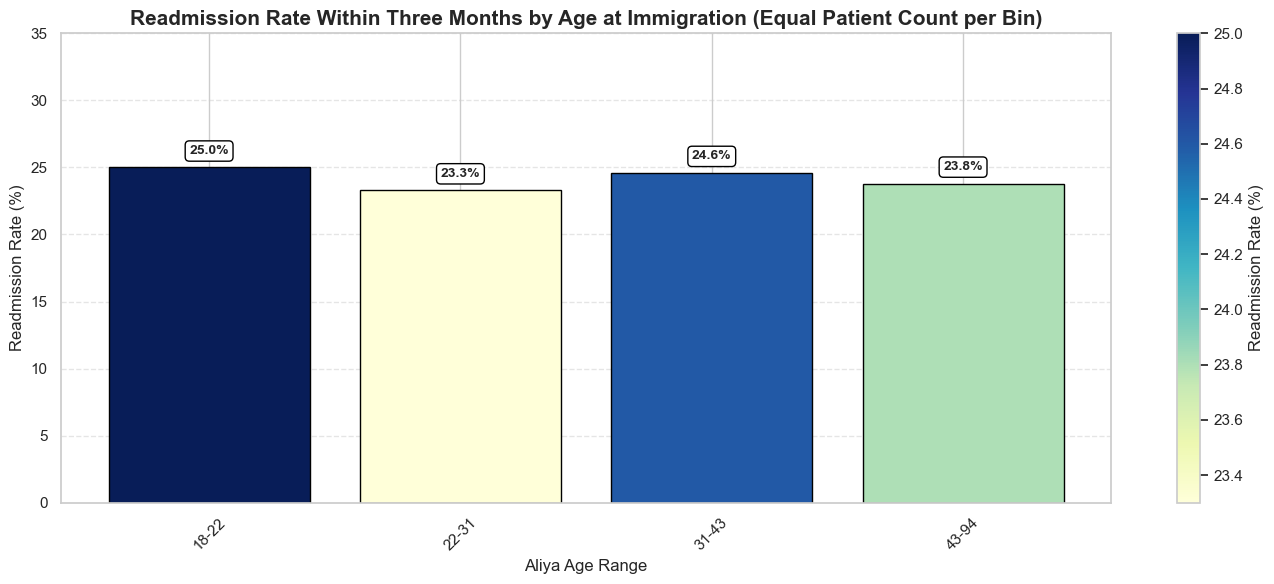


📊 Readmission Rate Within Three Months by Aliya Age Group (Equal Patient Count per Bin):

╒═══════════════════╤════════════════════════╤═════════╤══════════════════╕
│ Aliya Age Range   │   Readmission Rate (%) │   Count │   Returned Count │
╞═══════════════════╪════════════════════════╪═════════╪══════════════════╡
│ 18-22             │                   25   │     480 │              120 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 22-31             │                   23.3 │     480 │              112 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 31-43             │                   24.6 │     479 │              118 │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│ 43-94             │                   23.8 │     480 │              114 │
╘═══════════════════╧════════════════════════╧═════════╧══════════════════╛


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import matplotlib.cm as cm
import matplotlib.colors as colors

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Aliya Age"] = df["גיל עליה"] * (max_age - min_age) + min_age
df = df[df["Recovered Aliya Age"].notna()]
df["Recovered Aliya Age"] = df["Recovered Aliya Age"].astype(int)
df = df[df["Recovered Aliya Age"] >= 18]
df = df.sort_values("Recovered Aliya Age").reset_index(drop=True)

# 📌 חלוקה שווה לפי כמות מטופלים בכל קבוצה
patients_per_bin = 400
n_bins = len(df) // patients_per_bin
df['Bin'] = pd.qcut(df['Recovered Aliya Age'].rank(method='first'), q=n_bins, labels=False)

# 📌 חישוב מדדים לכל קבוצה
bins = []
for bin_id in sorted(df['Bin'].unique()):
    group = df[df['Bin'] == bin_id]
    min_age = group["Recovered Aliya Age"].min()
    max_age = group["Recovered Aliya Age"].max()
    readmission_rate = round(group["חזר לאשפוז תוך 3 חודשים"].mean() * 100, 1)
    bins.append({
        "Aliya Age Range": f"{min_age}-{max_age}",
        "Readmission Rate (%)": readmission_rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך 3 חודשים"].sum()
    })

# 📌 טבלה סופית
final_table = pd.DataFrame(bins)

# 📌 צבעים מדורגים לגרף
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min(),
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('YlGnBu')
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת גרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(final_table["Aliya Age Range"], final_table["Readmission Rate (%)"],
              color=bar_colors, edgecolor='black')

ax.set_title("Readmission Rate Within Three Months by Age at Immigration (Equal Patient Count per Bin)",
             fontsize=15, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)")
ax.set_xlabel("Aliya Age Range")
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Aliya Age Range"], rotation=45)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות מעל העמודות
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(i, value + 1, f"{value:.1f}%", ha='center', fontsize=10, fontweight='bold',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

# 📌 colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%)')

plt.tight_layout()
plt.show()

# 📌 טבלה מעוצבת
print("\n📊 Readmission Rate Within Three Months by Aliya Age Group (Equal Patient Count per Bin):\n")
print(tabulate(final_table, headers="keys", tablefmt="fancy_grid", showindex=False))


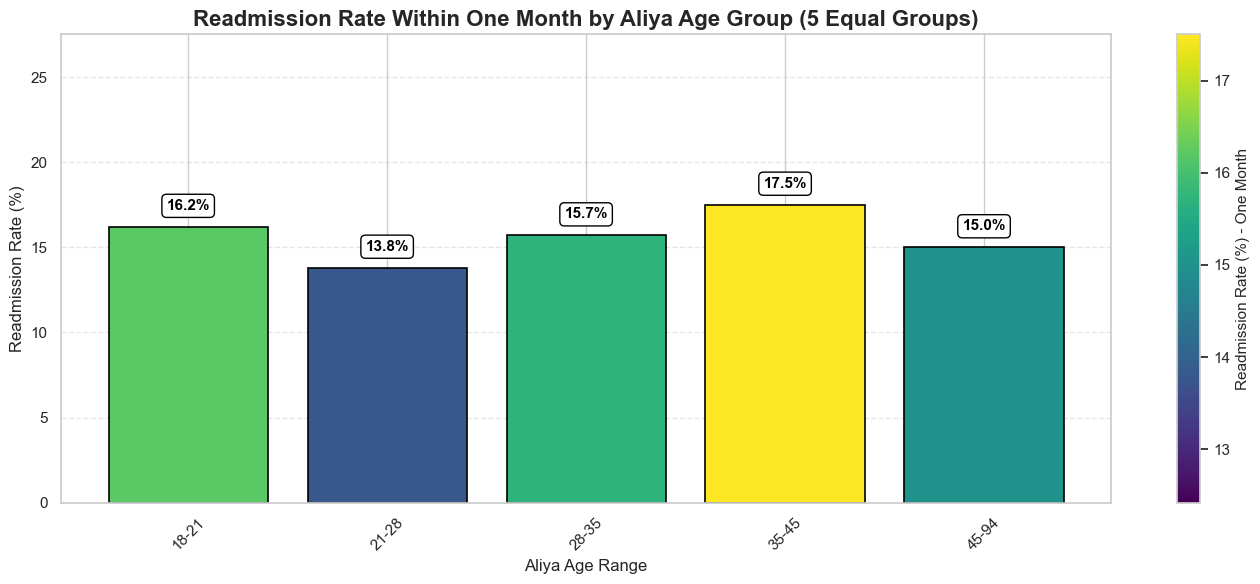


📊 Final Table - Readmission Rate Within One Month by Aliya Age Group:

╒═══════════════════╤════════════════════════╤═════════╤══════════════════╕
│  Aliya Age Range  │  Readmission Rate (%)  │  Count  │  Returned Count  │
╞═══════════════════╪════════════════════════╪═════════╪══════════════════╡
│       18-21       │          16.2          │   383   │        62        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       21-28       │          13.8          │   383   │        53        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       28-35       │          15.7          │   383   │        60        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       35-45       │          17.5          │   383   │        67        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       45-94       │           15           │   387   │        58        │
╘═══════════════

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Aliya Age"] = df["גיל עליה"] * (max_age - min_age) + min_age
df = df[df["Recovered Aliya Age"].notna()]
df["Recovered Aliya Age"] = df["Recovered Aliya Age"].astype(int)
df = df[df["Recovered Aliya Age"] >= 18]
df = df.sort_values("Recovered Aliya Age").reset_index(drop=True)

# 📌 חלוקה ל־5 קבוצות בגודל שווה
n_groups = 5
group_size = len(df) // n_groups
bins = []

for i in range(n_groups):
    group = df.iloc[i*group_size:(i+1)*group_size if i < n_groups-1 else len(df)]
    min_g = group["Recovered Aliya Age"].min()
    max_g = group["Recovered Aliya Age"].max()
    rate = round(group["חזר לאשפוז תוך חודש"].mean() * 100, 1)
    
    bins.append({
        "Aliya Age Range": f"{min_g}-{max_g}",
        "Readmission Rate (%)": rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך חודש"].sum()
    })

final_table = pd.DataFrame(bins)

# 📌 הגדרת צבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min() * 0.9,
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('viridis', 256)
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת הגרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(
    final_table["Aliya Age Range"],
    final_table["Readmission Rate (%)"],
    color=bar_colors,
    edgecolor='black',
    linewidth=1.2
)

ax.set_title("Readmission Rate Within One Month by Aliya Age Group (5 Equal Groups)", fontsize=16, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)", fontsize=12)
ax.set_xlabel("Aliya Age Range", fontsize=12)
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Aliya Age Range"], rotation=45, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות על כל עמודה
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(
        i, value + 1,
        f"{value:.1f}%",
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='black',
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            boxstyle='round,pad=0.3',
            alpha=1
        ),
        zorder=10
    )

# 📌 Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%) - One Month', fontsize=11)

plt.tight_layout()
plt.show()

# 📌 טבלה מעוצבת
print("\n📊 Final Table - Readmission Rate Within One Month by Aliya Age Group:\n")
print(tabulate(
    final_table,
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False,
    numalign='center',
    stralign='center'
))


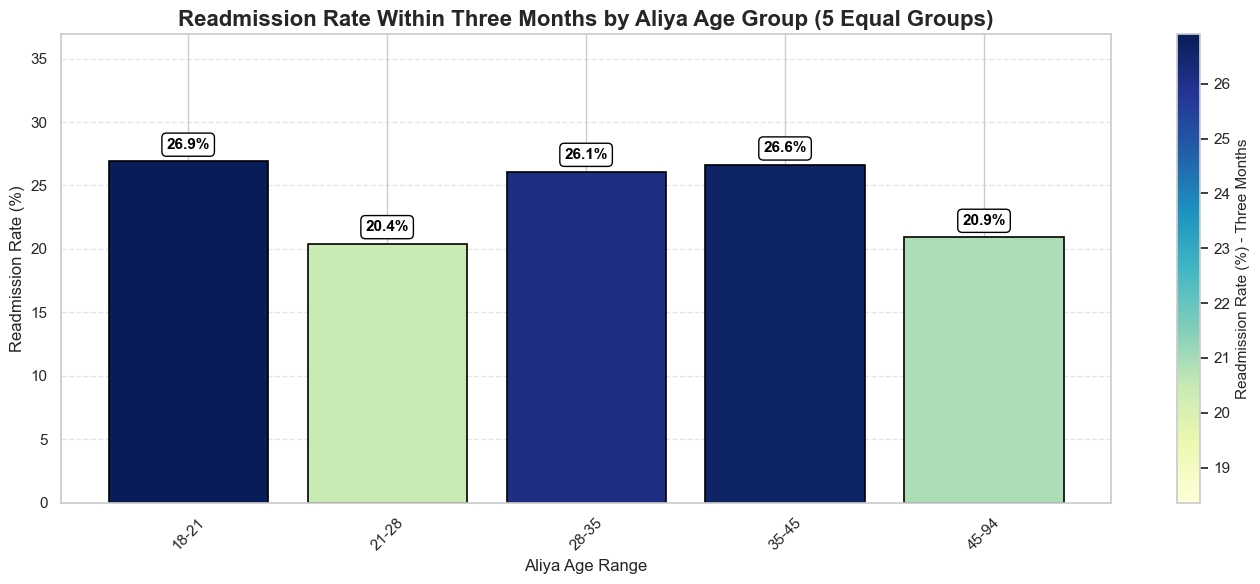


📊 Final Table - Readmission Rate Within Three Months by Aliya Age Group:

╒═══════════════════╤════════════════════════╤═════════╤══════════════════╕
│  Aliya Age Range  │  Readmission Rate (%)  │  Count  │  Returned Count  │
╞═══════════════════╪════════════════════════╪═════════╪══════════════════╡
│       18-21       │          26.9          │   383   │       103        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       21-28       │          20.4          │   383   │        78        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       28-35       │          26.1          │   383   │       100        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       35-45       │          26.6          │   383   │       102        │
├───────────────────┼────────────────────────┼─────────┼──────────────────┤
│       45-94       │          20.9          │   387   │        81        │
╘════════════

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import os
from tabulate import tabulate

# 📌 קריאת הקובץ
notebook_path = os.getcwd()
excel_path = os.path.join(
    notebook_path, "..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx"
)
df = pd.read_excel(excel_path)

# 📌 שחזור גיל עליה מתוך ערך מנורמל
min_age = 18
max_age = 94
df["Recovered Aliya Age"] = df["גיל עליה"] * (max_age - min_age) + min_age
df = df[df["Recovered Aliya Age"].notna()]
df["Recovered Aliya Age"] = df["Recovered Aliya Age"].astype(int)
df = df[df["Recovered Aliya Age"] >= 18]
df = df.sort_values("Recovered Aliya Age").reset_index(drop=True)

# 📌 חלוקה ל־5 קבוצות בגודל שווה
n_groups = 5
group_size = len(df) // n_groups
bins = []

for i in range(n_groups):
    group = df.iloc[i*group_size:(i+1)*group_size if i < n_groups-1 else len(df)]
    min_g = group["Recovered Aliya Age"].min()
    max_g = group["Recovered Aliya Age"].max()
    rate = round(group["חזר לאשפוז תוך 3 חודשים"].mean() * 100, 1)
    
    bins.append({
        "Aliya Age Range": f"{min_g}-{max_g}",
        "Readmission Rate (%)": rate,
        "Count": len(group),
        "Returned Count": group["חזר לאשפוז תוך 3 חודשים"].sum()
    })

final_table = pd.DataFrame(bins)

# 📌 הגדרת צבעים
norm = colors.Normalize(vmin=final_table["Readmission Rate (%)"].min() * 0.9,
                        vmax=final_table["Readmission Rate (%)"].max())
cmap = cm.get_cmap('YlGnBu', 256)
bar_colors = cmap(norm(final_table["Readmission Rate (%)"]))

# 📌 יצירת הגרף
fig, ax = plt.subplots(figsize=(14, 6))
bars = ax.bar(
    final_table["Aliya Age Range"],
    final_table["Readmission Rate (%)"],
    color=bar_colors,
    edgecolor='black',
    linewidth=1.2
)

ax.set_title("Readmission Rate Within Three Months by Aliya Age Group (5 Equal Groups)", fontsize=16, fontweight='bold')
ax.set_ylabel("Readmission Rate (%)", fontsize=12)
ax.set_xlabel("Aliya Age Range", fontsize=12)
ax.set_ylim(0, final_table["Readmission Rate (%)"].max() + 10)
ax.set_xticklabels(final_table["Aliya Age Range"], rotation=45, fontsize=11)
ax.tick_params(axis='y', labelsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.5)

# 📌 תוויות על כל עמודה
for i, value in enumerate(final_table["Readmission Rate (%)"]):
    ax.text(
        i, value + 1,
        f"{value:.1f}%",
        ha='center',
        fontsize=11,
        fontweight='bold',
        color='black',
        bbox=dict(
            facecolor='white',
            edgecolor='black',
            boxstyle='round,pad=0.3',
            alpha=1
        ),
        zorder=10
    )

# 📌 Colorbar
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax).set_label('Readmission Rate (%) - Three Months', fontsize=11)

plt.tight_layout()
plt.show()

# 📌 טבלה מעוצבת
print("\n📊 Final Table - Readmission Rate Within Three Months by Aliya Age Group:\n")
print(tabulate(
    final_table,
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False,
    numalign='center',
    stralign='center'
))


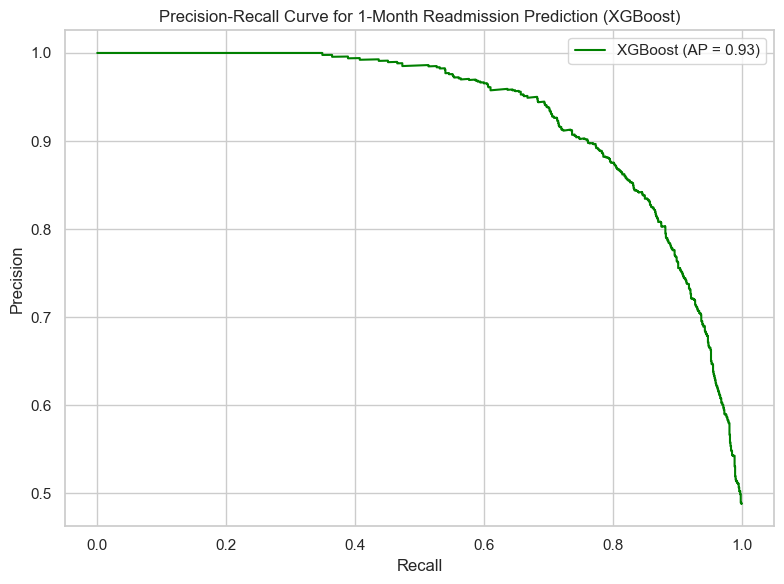

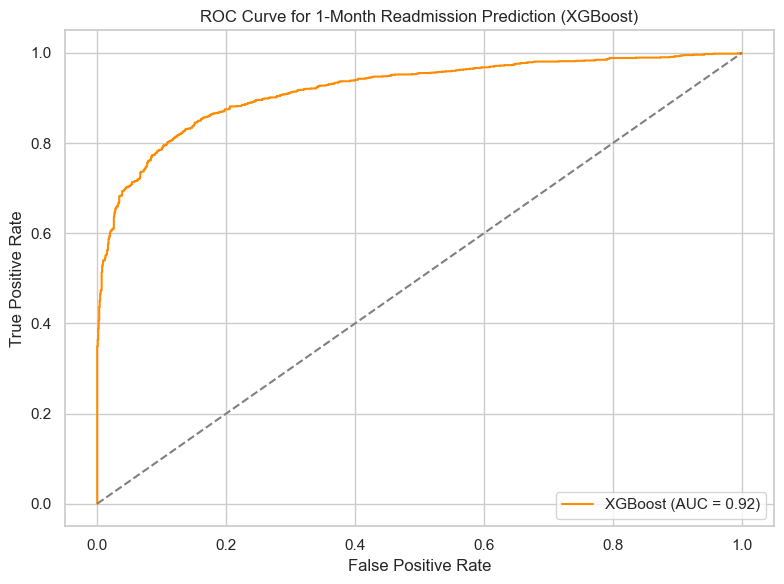


📊 XGBoost Model Performance Report – 1-Month Readmission:

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Not Readmitted     │        0.85 │ 0.85     │ 0.85       │ 1318      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.84 │ 0.84     │ 0.84       │ 1257      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg          │        0.85 │ 0.85     │ 0.85       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg       │        0.85 │ 0.85     │ 0.85       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.92 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────┼────

In [50]:
# 📌 Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tabulate import tabulate
import os

# 📌 Load Excel File
excel_path = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx")
df = pd.read_excel(excel_path)

# 📌 Drop ID columns
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')
target_col = "חזר לאשפוז תוך חודש"  # 🔁 Change to 3 חודשים if needed

# 📌 Define features and target
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# 📌 Apply SMOTE for class balancing
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 📌 Split into Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 📌 Train XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# 📌 Predict probabilities and labels
y_scores = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 📌 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {avg_precision:.2f})', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for 1-Month Readmission Prediction (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 1-Month Readmission Prediction (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Classification Report Table
report = classification_report(y_test, y_pred, output_dict=True)
table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        name = {"0": "Not Readmitted", "1": "Readmitted"}.get(label, label)
        table.append([
            name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['support']:.0f}"
        ])

# Add AUC and AP
table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

print("\n📊 XGBoost Model Performance Report – 1-Month Readmission:\n")
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))


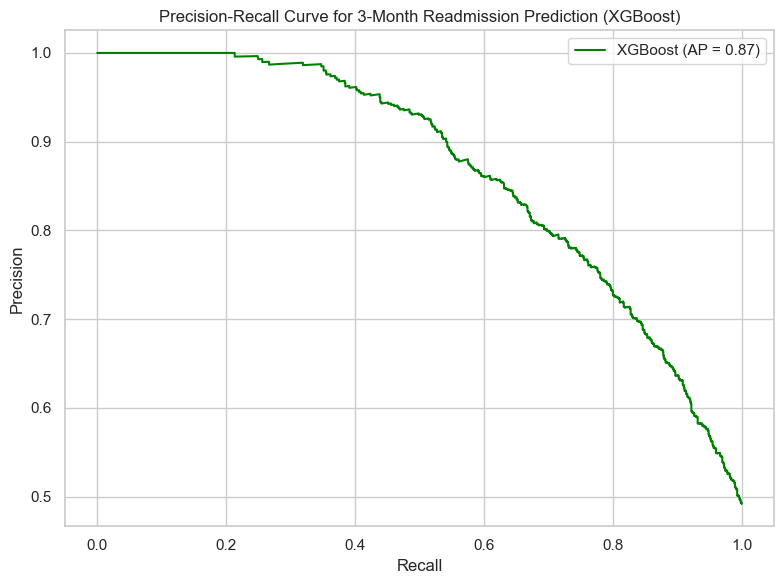

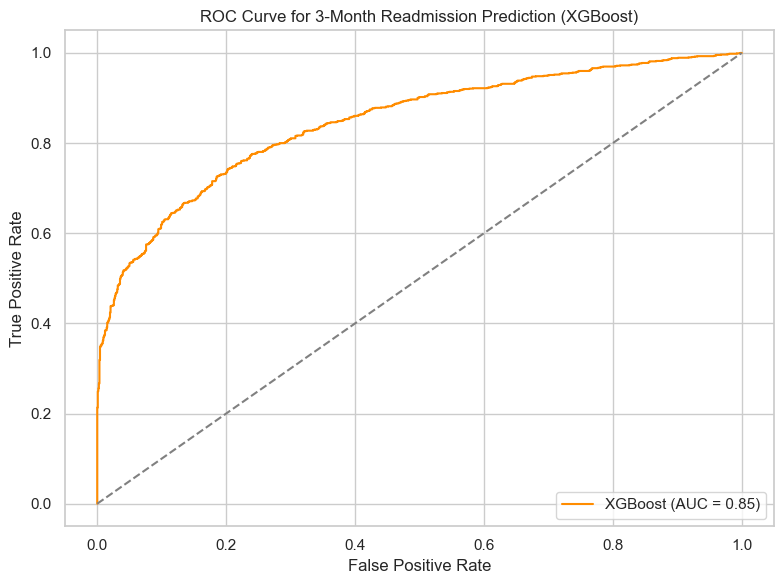


📊 XGBoost Model Performance Report – 3-Month Readmission:

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Not Readmitted     │        0.78 │ 0.75     │ 0.76       │ 1161      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.75 │ 0.78     │ 0.77       │ 1125      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg          │        0.76 │ 0.76     │ 0.76       │ 2286      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg       │        0.77 │ 0.76     │ 0.76       │ 2286      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.85 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────┼────

In [53]:
# 📌 Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from tabulate import tabulate
import os

# 📌 Load Excel File
excel_path = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx")
df = pd.read_excel(excel_path)

# 📌 Drop ID columns
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')
target_col = "חזר לאשפוז תוך 3 חודשים"  # ✅ הפעם זה לשלושה חודשים

# 📌 Define features and target
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# 📌 Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 📌 Split into Train/Test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# 📌 Train XGBoost model
model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# 📌 Predict
y_scores = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

# 📌 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'XGBoost (AP = {avg_precision:.2f})', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for 3-Month Readmission Prediction (XGBoost)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for 3-Month Readmission Prediction (XGBoost)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Performance Table
report = classification_report(y_test, y_pred, output_dict=True)
table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        name = {"0": "Not Readmitted", "1": "Readmitted"}.get(label, label)
        table.append([
            name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['support']:.0f}"
        ])

table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

print("\n📊 XGBoost Model Performance Report – 3-Month Readmission:\n")
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))


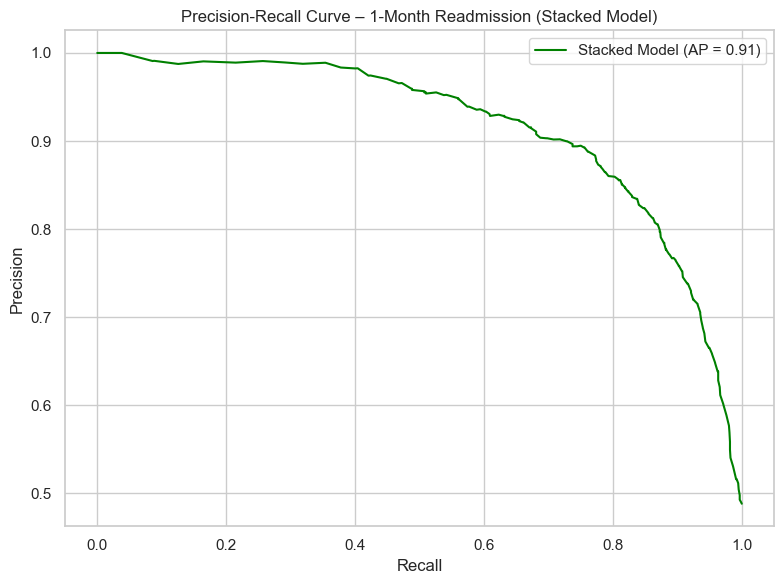

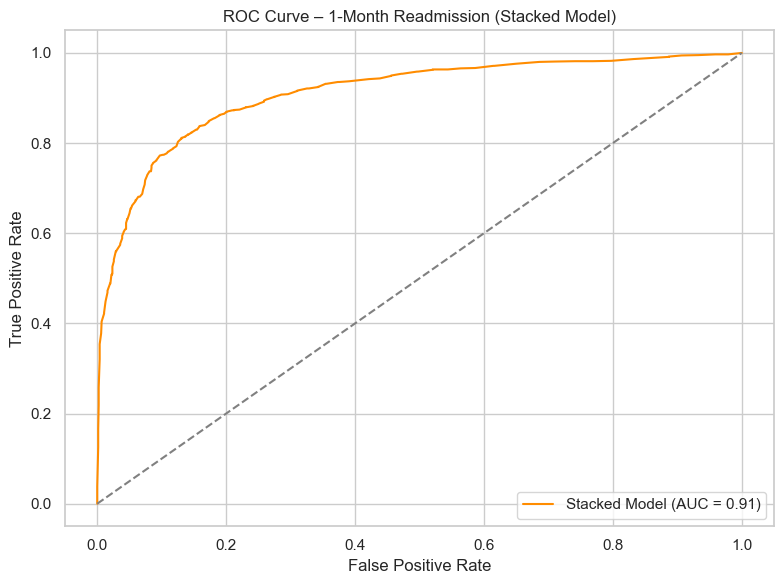


📊 Stacked Model Performance Report – 1-Month Readmission:

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Not Readmitted     │        0.83 │ 0.86     │ 0.85       │ 1318      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.85 │ 0.82     │ 0.83       │ 1257      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg          │        0.84 │ 0.84     │ 0.84       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg       │        0.84 │ 0.84     │ 0.84       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.91 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────┼────

In [55]:
# 📌 Library Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    roc_curve, roc_auc_score, classification_report
)
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import os

# 📌 Load Excel File
excel_path = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx")
df = pd.read_excel(excel_path)

# 📌 Drop random ID columns
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')
target_col = "חזר לאשפוז תוך חודש"

# 📌 Feature/Target Separation
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# 📌 Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 📌 Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# 📌 Define Base Learners and Final Estimator
base_learners = [
    ('xgb', XGBClassifier(
        n_estimators=200, learning_rate=0.1,
        max_depth=5, subsample=0.8, colsample_bytree=0.8,
        random_state=42, use_label_encoder=False, eval_metric='logloss'
    )),
    ('rf', RandomForestClassifier(
        n_estimators=150, max_depth=8,
        random_state=42, class_weight='balanced'
    ))
]

# 📌 Stacking Model
stacked_model = StackingClassifier(
    estimators=base_learners,
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    passthrough=True
)

# 📌 Train the Model
stacked_model.fit(X_train, y_train)

# 📌 Predictions and Scores
y_scores = stacked_model.predict_proba(X_test)[:, 1]
y_pred = stacked_model.predict(X_test)

# 📌 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Stacked Model (AP = {avg_precision:.2f})', color='green')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – 1-Month Readmission (Stacked Model)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Stacked Model (AUC = {roc_auc:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – 1-Month Readmission (Stacked Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📌 Classification Report Table
report = classification_report(y_test, y_pred, output_dict=True)
table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        name = {"0": "Not Readmitted", "1": "Readmitted"}.get(label, label)
        table.append([
            name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['support']:.0f}"
        ])

# Add AUC and AP
table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

print("\n📊 Stacked Model Performance Report – 1-Month Readmission:\n")
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))


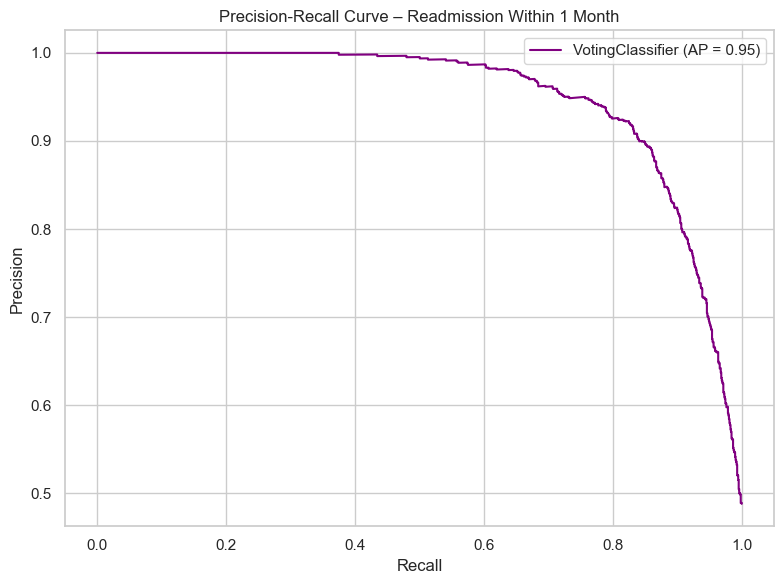

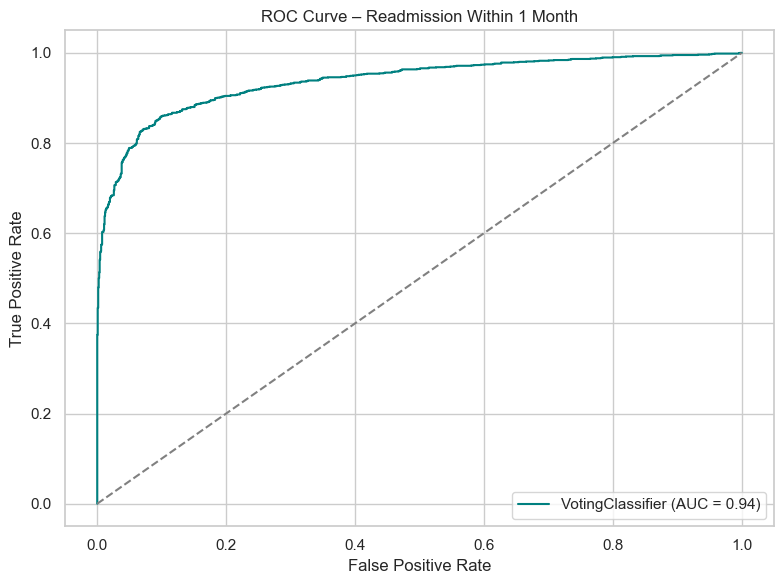


📊 VotingClassifier Performance Report – Readmission Within 1 Month:

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Not Readmitted     │        0.88 │ 0.86     │ 0.87       │ 1318      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.86 │ 0.88     │ 0.87       │ 1257      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg          │        0.87 │ 0.87     │ 0.87       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg       │        0.87 │ 0.87     │ 0.87       │ 2575      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.94 │          │            │           │
├────────────────────┼─────────────┼──────────┼───────

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import os

# Load dataset
excel_path = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx")
df = pd.read_excel(excel_path)
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# Target: readmission within 1 month
target_col = "חזר לאשפוז תוך חודש"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define models
cat = CatBoostClassifier(verbose=0, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# VotingClassifier
voting_model = VotingClassifier(
    estimators=[('cat', cat), ('xgb', xgb), ('rf', rf)],
    voting='soft'
)
voting_model.fit(X_train, y_train)

# Predictions
y_scores = voting_model.predict_proba(X_test)[:, 1]
y_pred = voting_model.predict(X_test)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'VotingClassifier (AP = {avg_precision:.2f})', color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Readmission Within 1 Month")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_1month.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'VotingClassifier (AUC = {roc_auc:.2f})', color='teal')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Readmission Within 1 Month")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_1month.png", dpi=300)
plt.show()

# Report Table
report = classification_report(y_test, y_pred, output_dict=True)
table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        name = {"0": "Not Readmitted", "1": "Readmitted"}.get(label, label)
        table.append([
            name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['support']:.0f}"
        ])
table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

# Save table to CSV
df_report = pd.DataFrame(table, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
df_report.to_csv("voting_classifier_1month_report.csv", index=False)

# Print for reference
print("\n📊 VotingClassifier Performance Report – Readmission Within 1 Month:\n")
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))


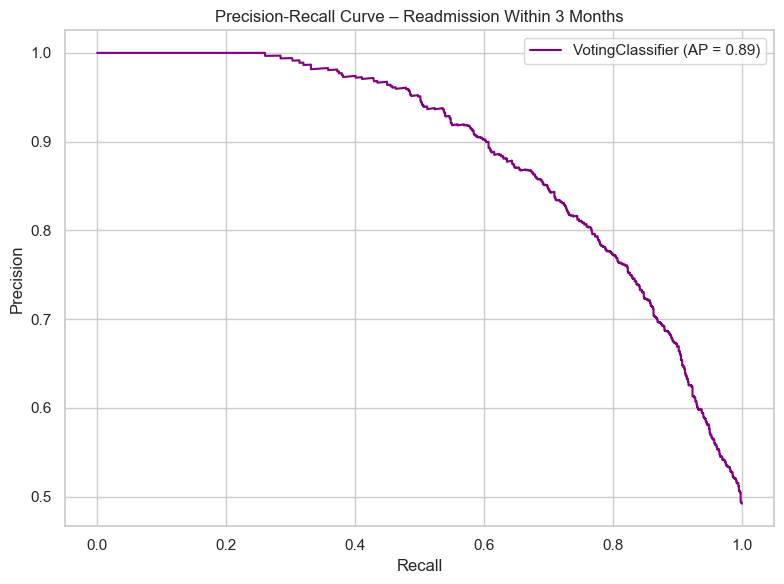

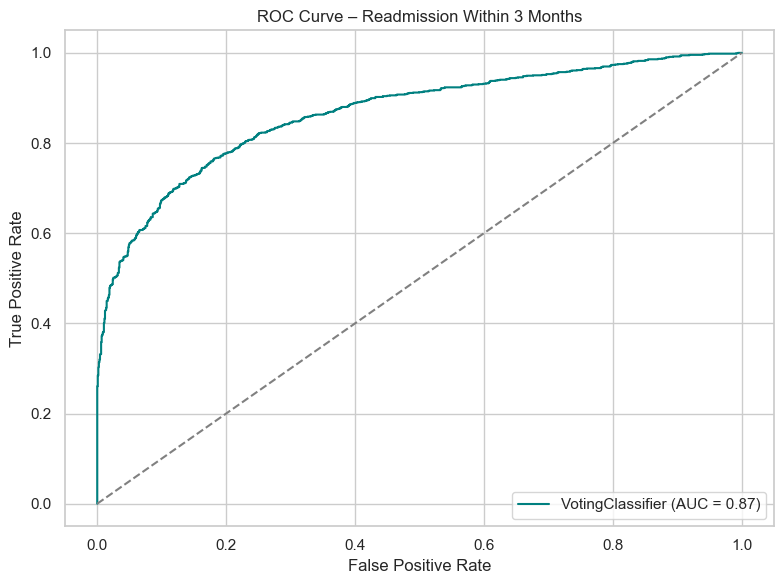


📊 VotingClassifier Performance Report – 3-Month Readmission:

╒════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Class              │   Precision │ Recall   │ F1-Score   │ Support   │
╞════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Not Readmitted     │        0.81 │ 0.75     │ 0.78       │ 1161      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Readmitted         │        0.76 │ 0.82     │ 0.79       │ 1125      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg          │        0.79 │ 0.78     │ 0.78       │ 2286      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg       │        0.79 │ 0.78     │ 0.78       │ 2286      │
├────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ROC AUC            │        0.87 │          │            │           │
├────────────────────┼─────────────┼──────────┼────────────┼─

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from tabulate import tabulate
import os

# Load dataset
excel_path = os.path.join("..", "Excel_Updates", "Update 48 - Month Dummy Comparison", "month_year.xlsx")
df = pd.read_excel(excel_path)
df.drop(columns=["מספר מטופל רנדומלי", "מספר מקרה אשפוז רנדומלי"], inplace=True, errors='ignore')

# Target: readmission within 3 months
target_col = "חזר לאשפוז תוך 3 חודשים"
X = df.drop(columns=["חזר לאשפוז תוך חודש", "חזר לאשפוז תוך 3 חודשים"], errors='ignore')
y = df[target_col]
X.fillna(X.mean(), inplace=True)

# SMOTE balancing
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Define models
cat = CatBoostClassifier(verbose=0, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)

# VotingClassifier
voting_model = VotingClassifier(
    estimators=[('cat', cat), ('xgb', xgb), ('rf', rf)],
    voting='soft'
)
voting_model.fit(X_train, y_train)

# Predictions
y_scores = voting_model.predict_proba(X_test)[:, 1]
y_pred = voting_model.predict(X_test)

# Precision-Recall
precision, recall, _ = precision_recall_curve(y_test, y_scores)
avg_precision = average_precision_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'VotingClassifier (AP = {avg_precision:.2f})', color='purple')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Readmission Within 3 Months")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("precision_recall_3month.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'VotingClassifier (AUC = {roc_auc:.2f})', color='teal')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Readmission Within 3 Months")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_3month.png", dpi=300)
plt.show()

# Report
report = classification_report(y_test, y_pred, output_dict=True)
table = []
for label, metrics in report.items():
    if isinstance(metrics, dict):
        name = {"0": "Not Readmitted", "1": "Readmitted"}.get(label, label)
        table.append([
            name,
            f"{metrics['precision']:.2f}",
            f"{metrics['recall']:.2f}",
            f"{metrics['f1-score']:.2f}",
            f"{metrics['support']:.0f}"
        ])
table.append(["ROC AUC", f"{roc_auc:.2f}", "", "", ""])
table.append(["Avg Precision (AP)", f"{avg_precision:.2f}", "", "", ""])

# Save table as CSV for future use
df_report = pd.DataFrame(table, columns=["Class", "Precision", "Recall", "F1-Score", "Support"])
df_report.to_csv("voting_classifier_3month_report.csv", index=False)

# Print summary table
print("\n📊 VotingClassifier Performance Report – 3-Month Readmission:\n")
print(tabulate(table, headers=["Class", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))
